In [2]:
pip install basemap

Note: you may need to restart the kernel to use updated packages.


In [16]:
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import json

import watermark

%load_ext watermark
%matplotlib inline

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [17]:
plt.style.use('./d4sci.mplstyle')

## Block map

We're going to build up a block map of the number of cases in each state. We start by loading up the most recent data frrom the JHU github repository

In [18]:
confirmed_US = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')

And clean it up so that we have just totals per state

In [19]:
del_columns = [
 'UID',
 'iso2',
 'iso3',
 'code3',
 'FIPS',
 'Admin2',
 'Country_Region',
 'Lat',
 'Long_',
 'Combined_Key',
]

In [20]:
confirmed_US.drop(columns=del_columns, inplace=True)
confirmed_US = confirmed_US.groupby('Province_State').sum().T
confirmed_US.index = pd.to_datetime(confirmed_US.index)
confirmed_US = confirmed_US.diff(1).rolling(7).mean()

So we finally have:

In [21]:
confirmed_US

Province_State     Alabama      Alaska  American Samoa     Arizona  \
2020-01-22             NaN         NaN             NaN         NaN   
2020-01-23             NaN         NaN             NaN         NaN   
2020-01-24             NaN         NaN             NaN         NaN   
2020-01-25             NaN         NaN             NaN         NaN   
2020-01-26             NaN         NaN             NaN         NaN   
...                    ...         ...             ...         ...   
2020-10-02      862.857143  117.000000             0.0  485.142857   
2020-10-03      969.857143  121.428571             0.0  510.428571   
2020-10-04      978.285714  132.000000             0.0  502.428571   
2020-10-05      961.428571  145.142857             0.0  508.571429   
2020-10-06      989.000000  147.142857             0.0  535.714286   

Province_State    Arkansas   California    Colorado  Connecticut    Delaware  \
2020-01-22             NaN          NaN         NaN          NaN         NaN   
2020-01-23             NaN          NaN         NaN          NaN         NaN   
2020-01-24             NaN          NaN         NaN          NaN         NaN   
2020-01-25             NaN          NaN         NaN          NaN         NaN   
2020-01-26             NaN          NaN         NaN          NaN         NaN   
...                    ...          ...         ...          ...         ...   
2020-10-02      833.285714  3193.285714  567.285714   244.285714  121.714286   
2020-10-03      824.285714  3152.857143  577.714286   244.285714  138.428571   
2020-10-04      824.428571  3260.428571  570.857143   244.285714  140.428571   
2020-10-05      768.714286  3256.571429  578.000000   281.857143  139.142857   
2020-10-06      759.428571  3221.142857  595.000000   273.142857  133.571429   

Province_State  Diamond Princess  ...    Tennessee        Texas         Utah  \
2020-01-22                   NaN  ...          NaN          NaN          NaN   
2020-01-23                   NaN  ...          NaN          NaN          NaN   
2020-01-24                   NaN  ...          NaN          NaN          NaN   
2020-01-25                   NaN  ...          NaN          NaN          NaN   
2020-01-26                   NaN  ...          NaN          NaN          NaN   
...                          ...  ...          ...          ...          ...   
2020-10-02                   0.0  ...  1278.428571  4462.571429   946.714286   
2020-10-03                   0.0  ...  1243.428571  4730.571429   954.000000   
2020-10-04                   0.0  ...  1173.571429  4491.142857  1000.428571   
2020-10-05                   0.0  ...  1423.857143  4731.571429  1040.142857   
2020-10-06                   0.0  ...  1537.714286  4472.142857  1043.285714   

Province_State    Vermont  Virgin Islands    Virginia  Washington  \
2020-01-22            NaN             NaN         NaN         NaN   
2020-01-23            NaN             NaN         NaN         NaN   
2020-01-24            NaN             NaN         NaN         NaN   
2020-01-25            NaN             NaN         NaN         NaN   
2020-01-26            NaN             NaN         NaN         NaN   
...                   ...             ...         ...         ...   
2020-10-02       5.285714        4.285714  742.285714  512.000000   
2020-10-03       5.571429        1.428571  759.428571  512.714286   
2020-10-04       6.142857        1.428571  805.857143  515.000000   
2020-10-05      10.285714        0.571429  839.714286  519.714286   
2020-10-06      10.285714        0.428571  800.000000  517.285714   

Province_State  West Virginia    Wisconsin     Wyoming  
2020-01-22                NaN          NaN         NaN  
2020-01-23                NaN          NaN         NaN  
2020-01-24                NaN          NaN         NaN  
2020-01-25                NaN          NaN         NaN  
2020-01-26                NaN          NaN         NaN  
...                       ...          ...         ...  
2020-10-0

We load up the information on the state location for our block map. The x and y coordinates correspond to the location of the states in our map.

In [22]:
states = pd.read_csv('data/states.csv', index_col=0)
states.head()

x  y        name
index                  
AL     7  6     Alabama
AK     0  1      Alaska
AZ     2  5     Arizona
AR     5  5    Arkansas
CA     1  4  California

And rename the columns to use the state abbreviations for simplicity

In [23]:
col_dict = dict(states.reset_index()[['name', 'index']].values)
confirmed_US.rename(columns=col_dict, inplace=True)

And finally we can make our plot

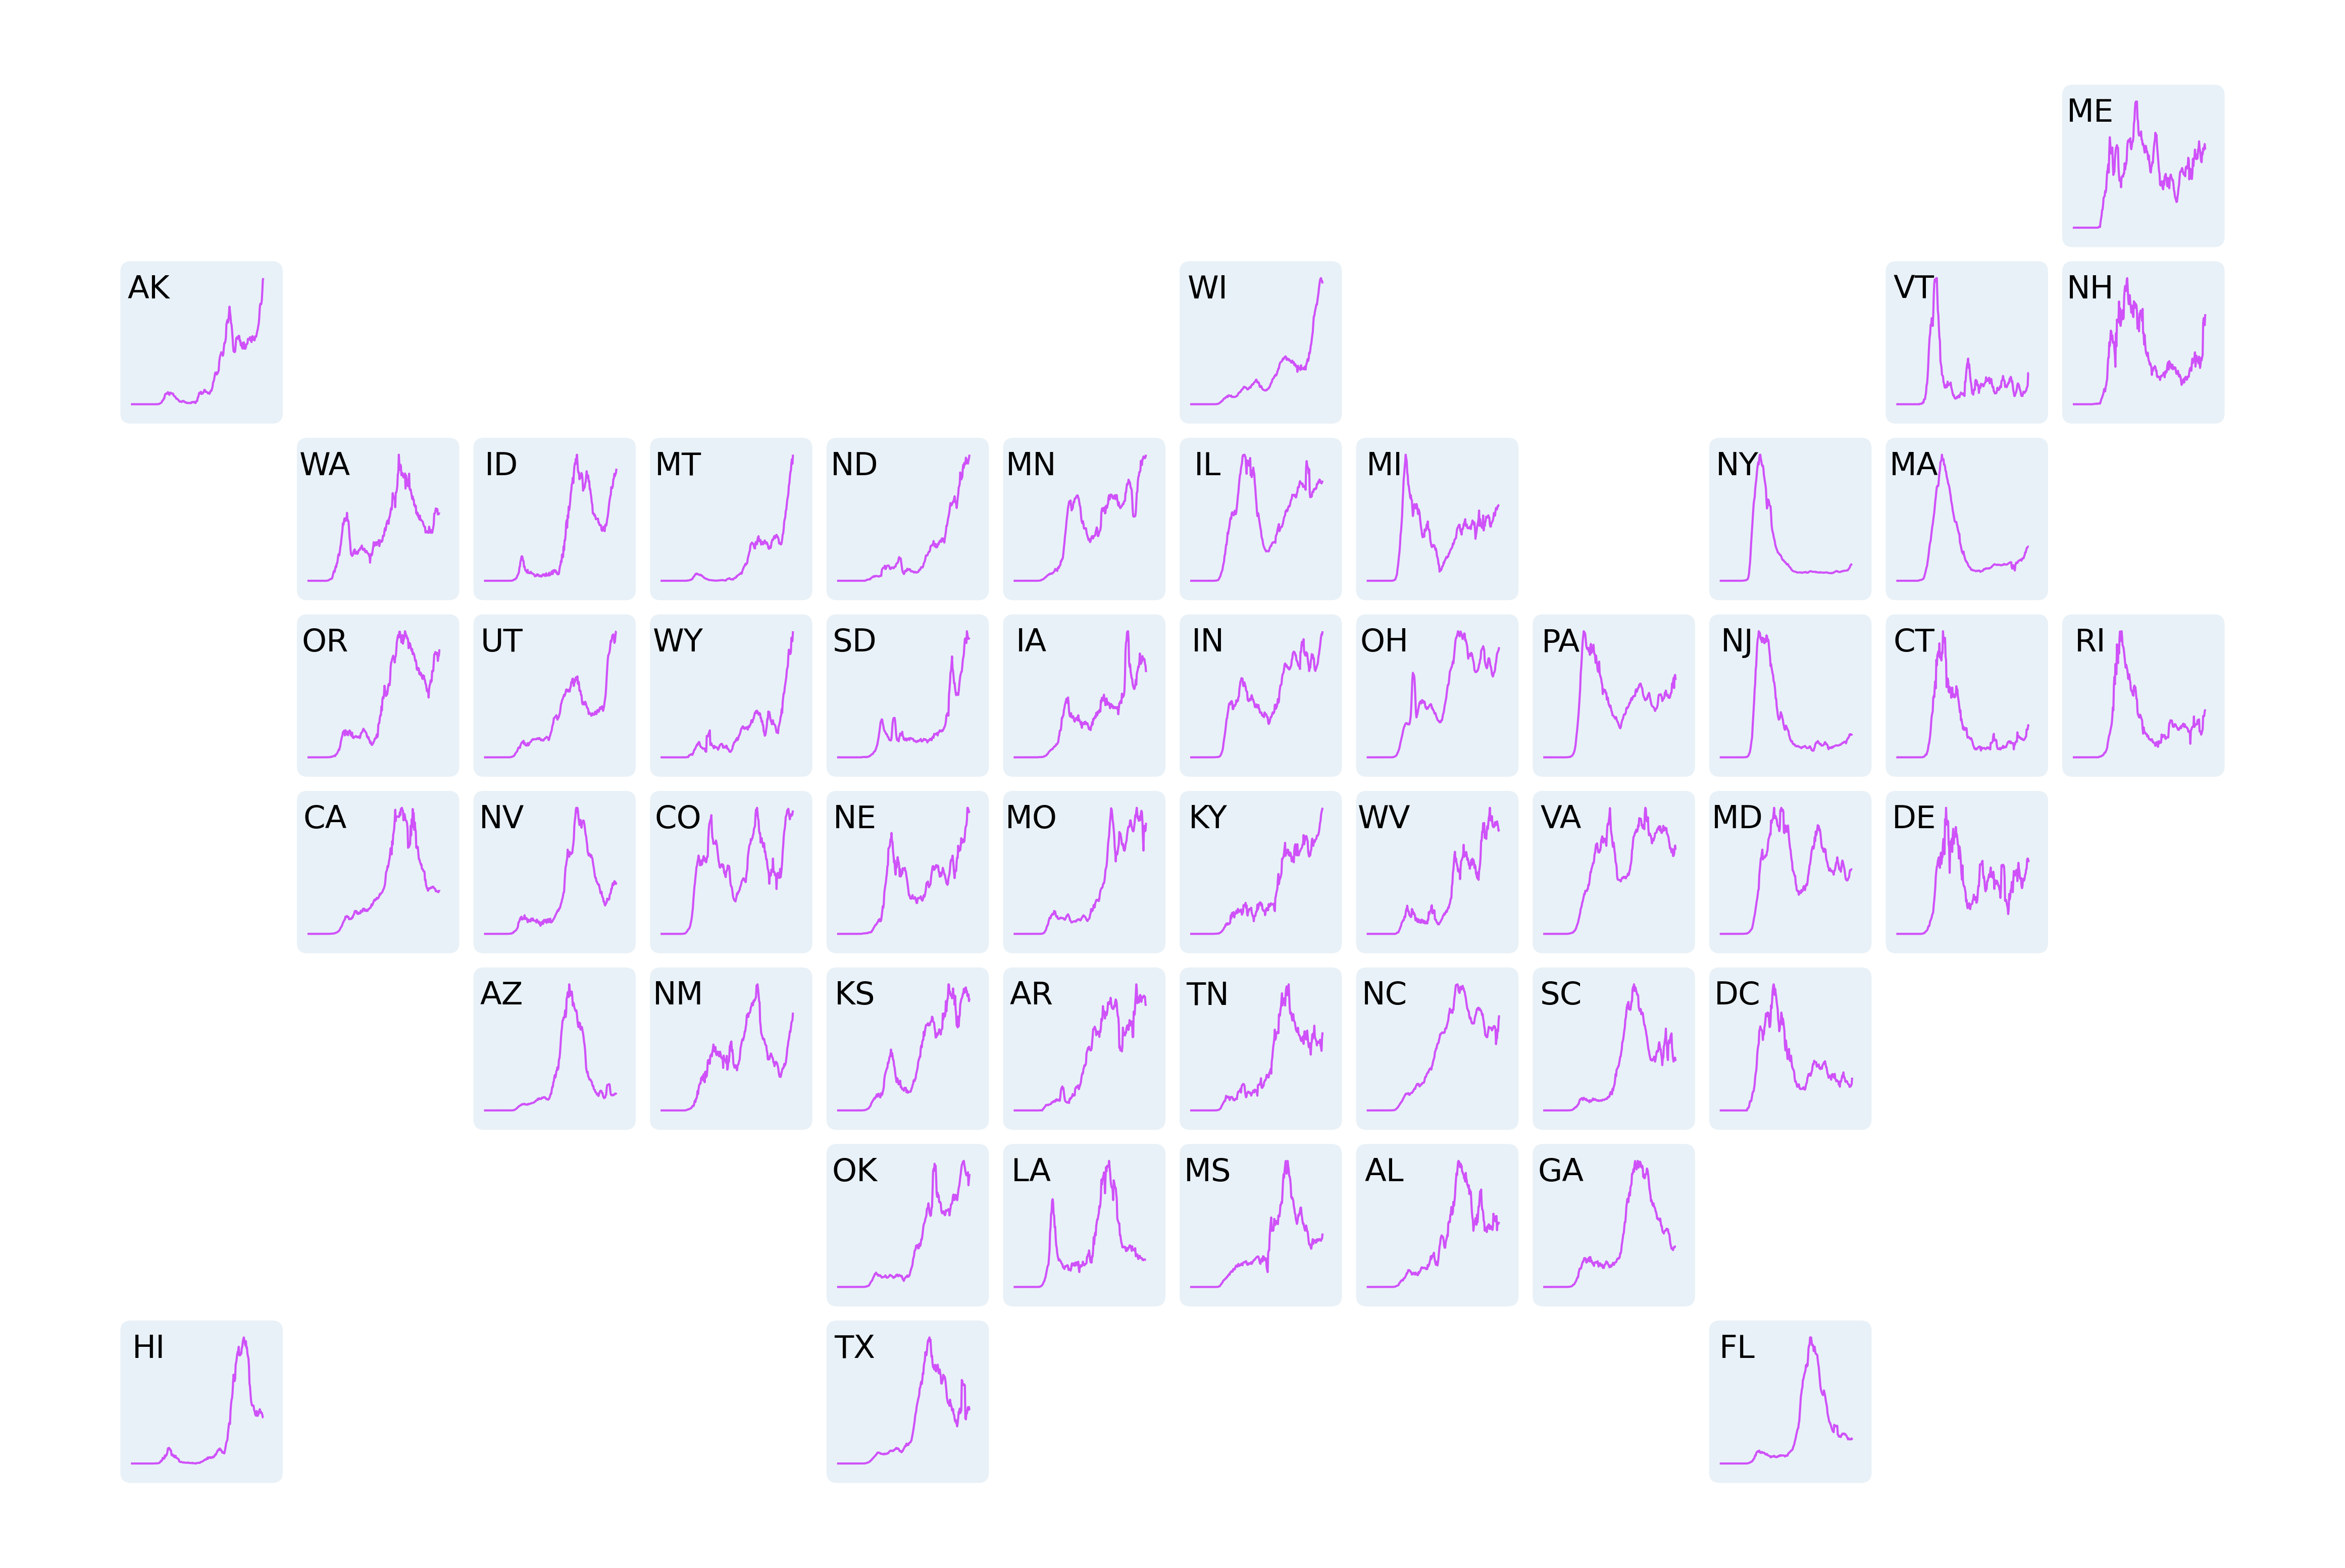

In [24]:
fig, ax = plt.subplots(1, figsize=(16, 22))
ax.set_aspect(1.)
ax.invert_yaxis()

# Each state will be represented by a "FancyBox" patch
patches = []

for state in states.index:
    fancybox = mpatches.FancyBboxPatch([states.x[state]-0.5, states.y[state]-0.5], 0.8, 0.8,
        boxstyle=mpatches.BoxStyle("Round", pad=0.06))
    patches.append(fancybox)

# Add the patches to the plot
collection = PatchCollection(patches, facecolors='#1f77b4', alpha=0.1)
ax.add_collection(collection)

# Finally add the timelines for each state at the corresponding location
x = np.linspace(0., 0.75, confirmed_US.shape[0])

for state in states.index:
    # Timelines are normalized so that they fit within the fancy box.
    timeline = (confirmed_US[state]/(confirmed_US[state].max()*1.4)).fillna(0).values
    
    ax.text(y=states.y[state]-0.4, x=states.x[state]-0.4, 
            s=state, horizontalalignment='center', verticalalignment='center', fontsize=15)
    ax.plot(states.x[state]+x-0.5, states.y[state]-timeline+0.25, lw=1, color='#cf51f9')
    
ax.axis('off')
fig.tight_layout()

## Manhattan

We are going to use some geographical boundary information for the borough of Manhattan. For simplicity I've extracted the necessary data from the official shapefiles https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm. In this format the data can be easily loaded:

In [25]:
manhattan = json.loads(open("data/Manhattan.json", "rt").readline())

points = np.array(manhattan["points"])
parts = manhattan["parts"]

The data (similarly to shapefiles) is composed of a list of 2D points:

In [26]:
points

array([[-74.01092841,  40.68449147],
       [-74.0119326 ,  40.68388775],
       [-74.01217597,  40.68409519],
       ...,
       [-73.90682823,  40.87663155],
       [-73.90682004,  40.87658553],
       [-73.906651  ,  40.8757525 ]])

And indicators of which points belong to which line.

In [27]:
parts

[0,
 12,
 17,
 22,
 27,
 75,
 81,
 362,
 369,
 377,
 388,
 393,
 399,
 429,
 440,
 447,
 455,
 463,
 474,
 483,
 488,
 493,
 501,
 534,
 542,
 560,
 728,
 758,
 1004,
 6091,
 6104,
 6332,
 6332,
 6332]

This means that the first line is made up of points in position $[0:12)$, the second line of the points $[12:17)$, etc. We can now use this data to easily get a quick map of Manhattan. I've purposefully let matplotlib set the color for each individual line so that we can easily see the different parts of the figure

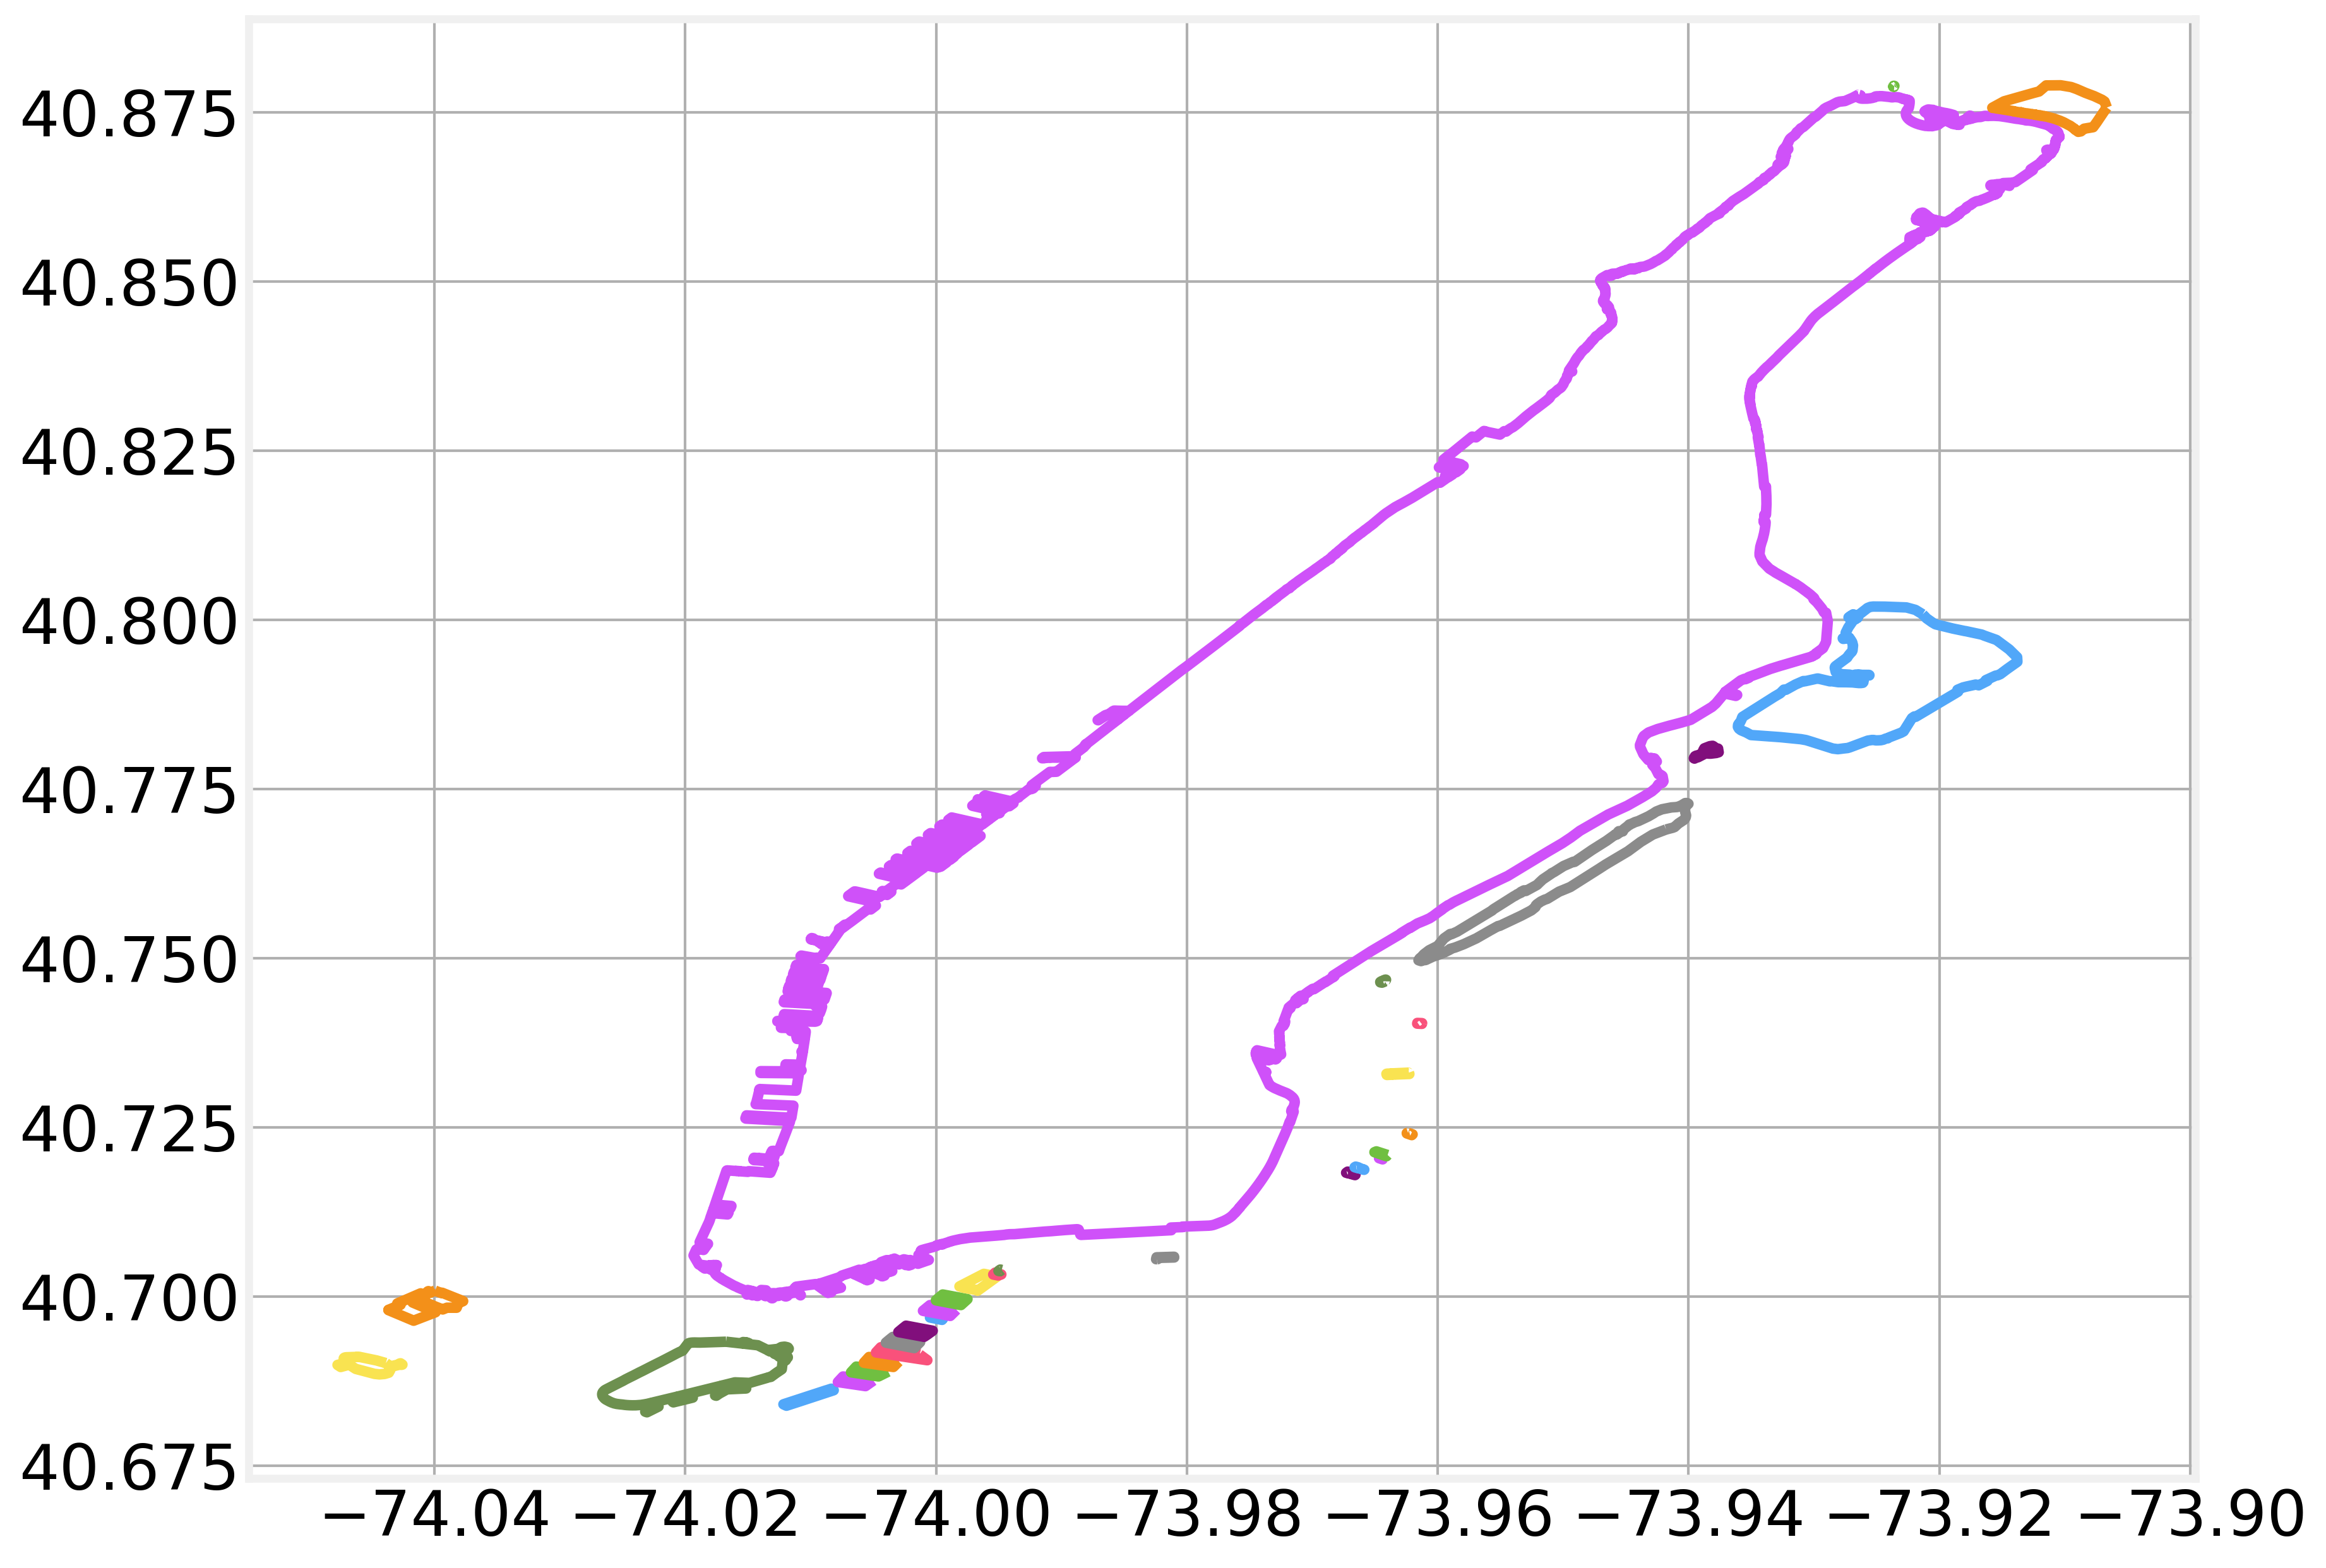

In [28]:
for i in range(len(parts)-1):
	plt.plot(points.T[0][parts[i]:parts[i+1]], points.T[1][parts[i]:parts[i+1]])

Let's add some points stored in a csv file of x, y coordinates

In [29]:
tweets = pd.read_csv('data/tweets.csv')

These are coordinates of real people tweeting with GPS locations enabled on a specific day:

In [30]:
tweets.head()

X          Y
0 -73.997017  40.762337
1 -73.968542  40.780709
2 -73.985962  40.760342
3 -73.952610  40.810797
4 -73.968542  40.780709

We can now easily plot these points along side the geographical boundaries

In [31]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

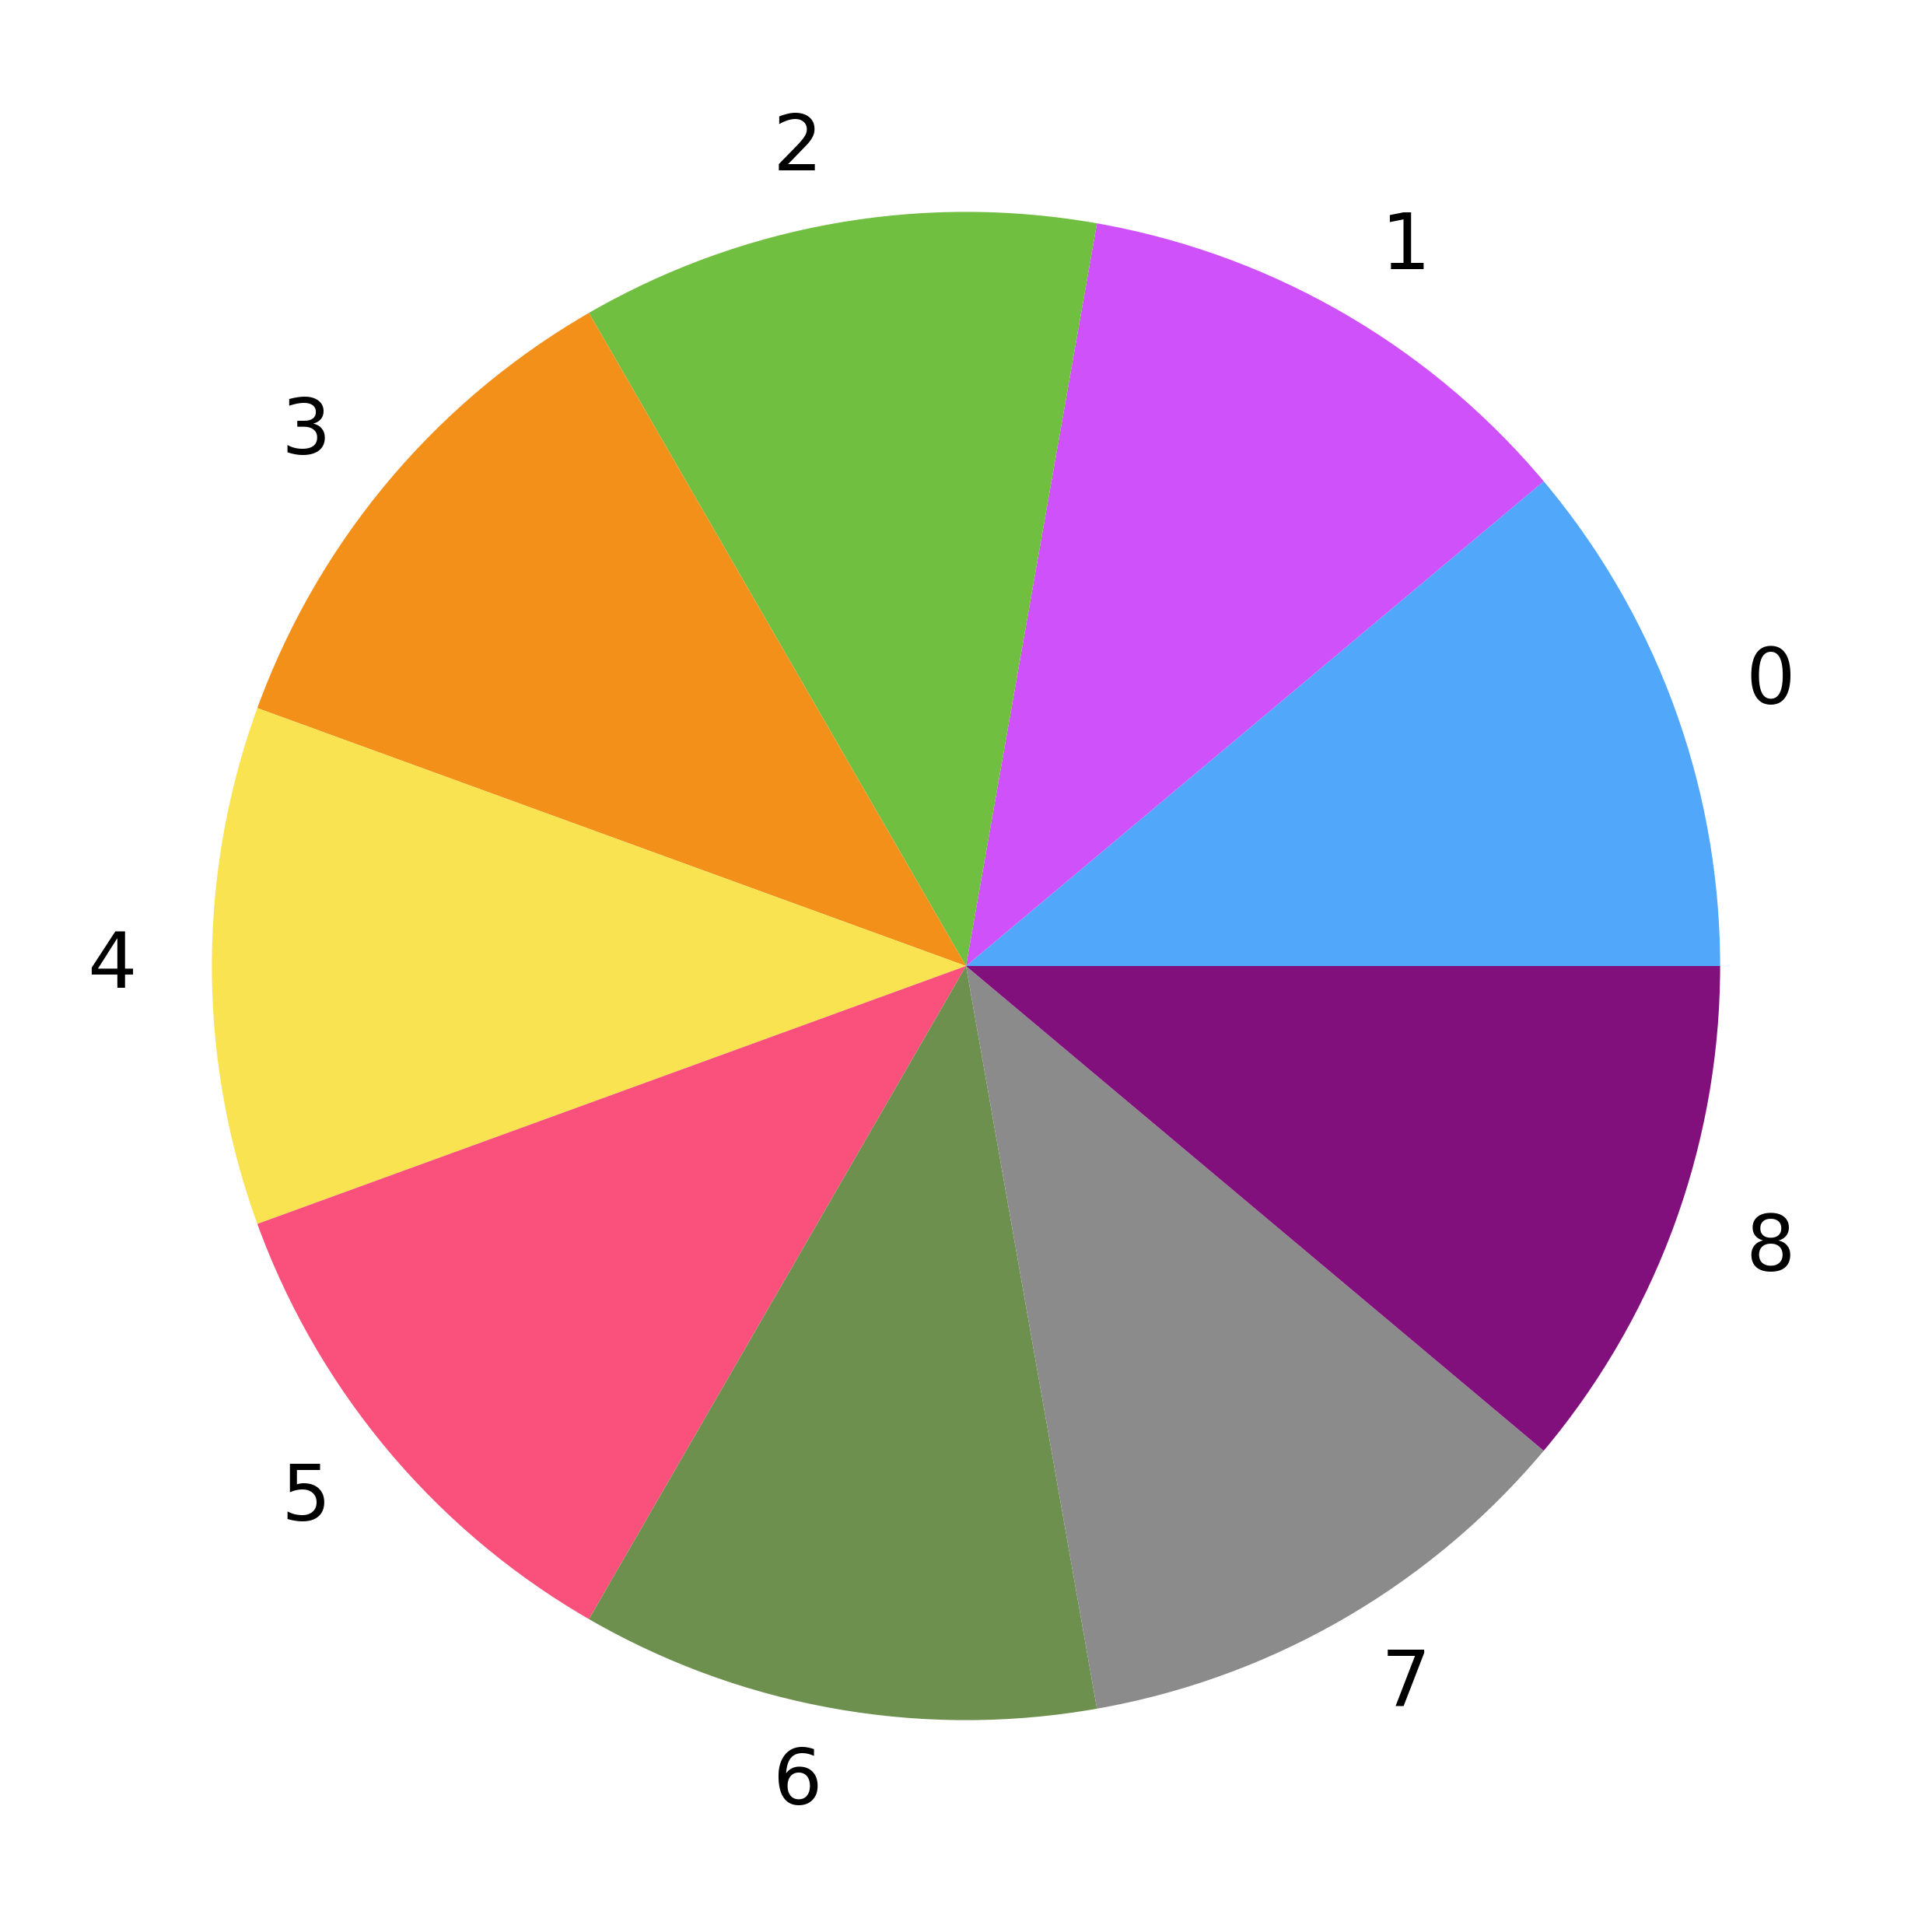

In [32]:
plt.pie(np.ones(len(colors)), labels=np.arange(len(colors)));

(-74.05478355854918, -73.89959706381602, 40.673110890352014, 40.88884410240033)

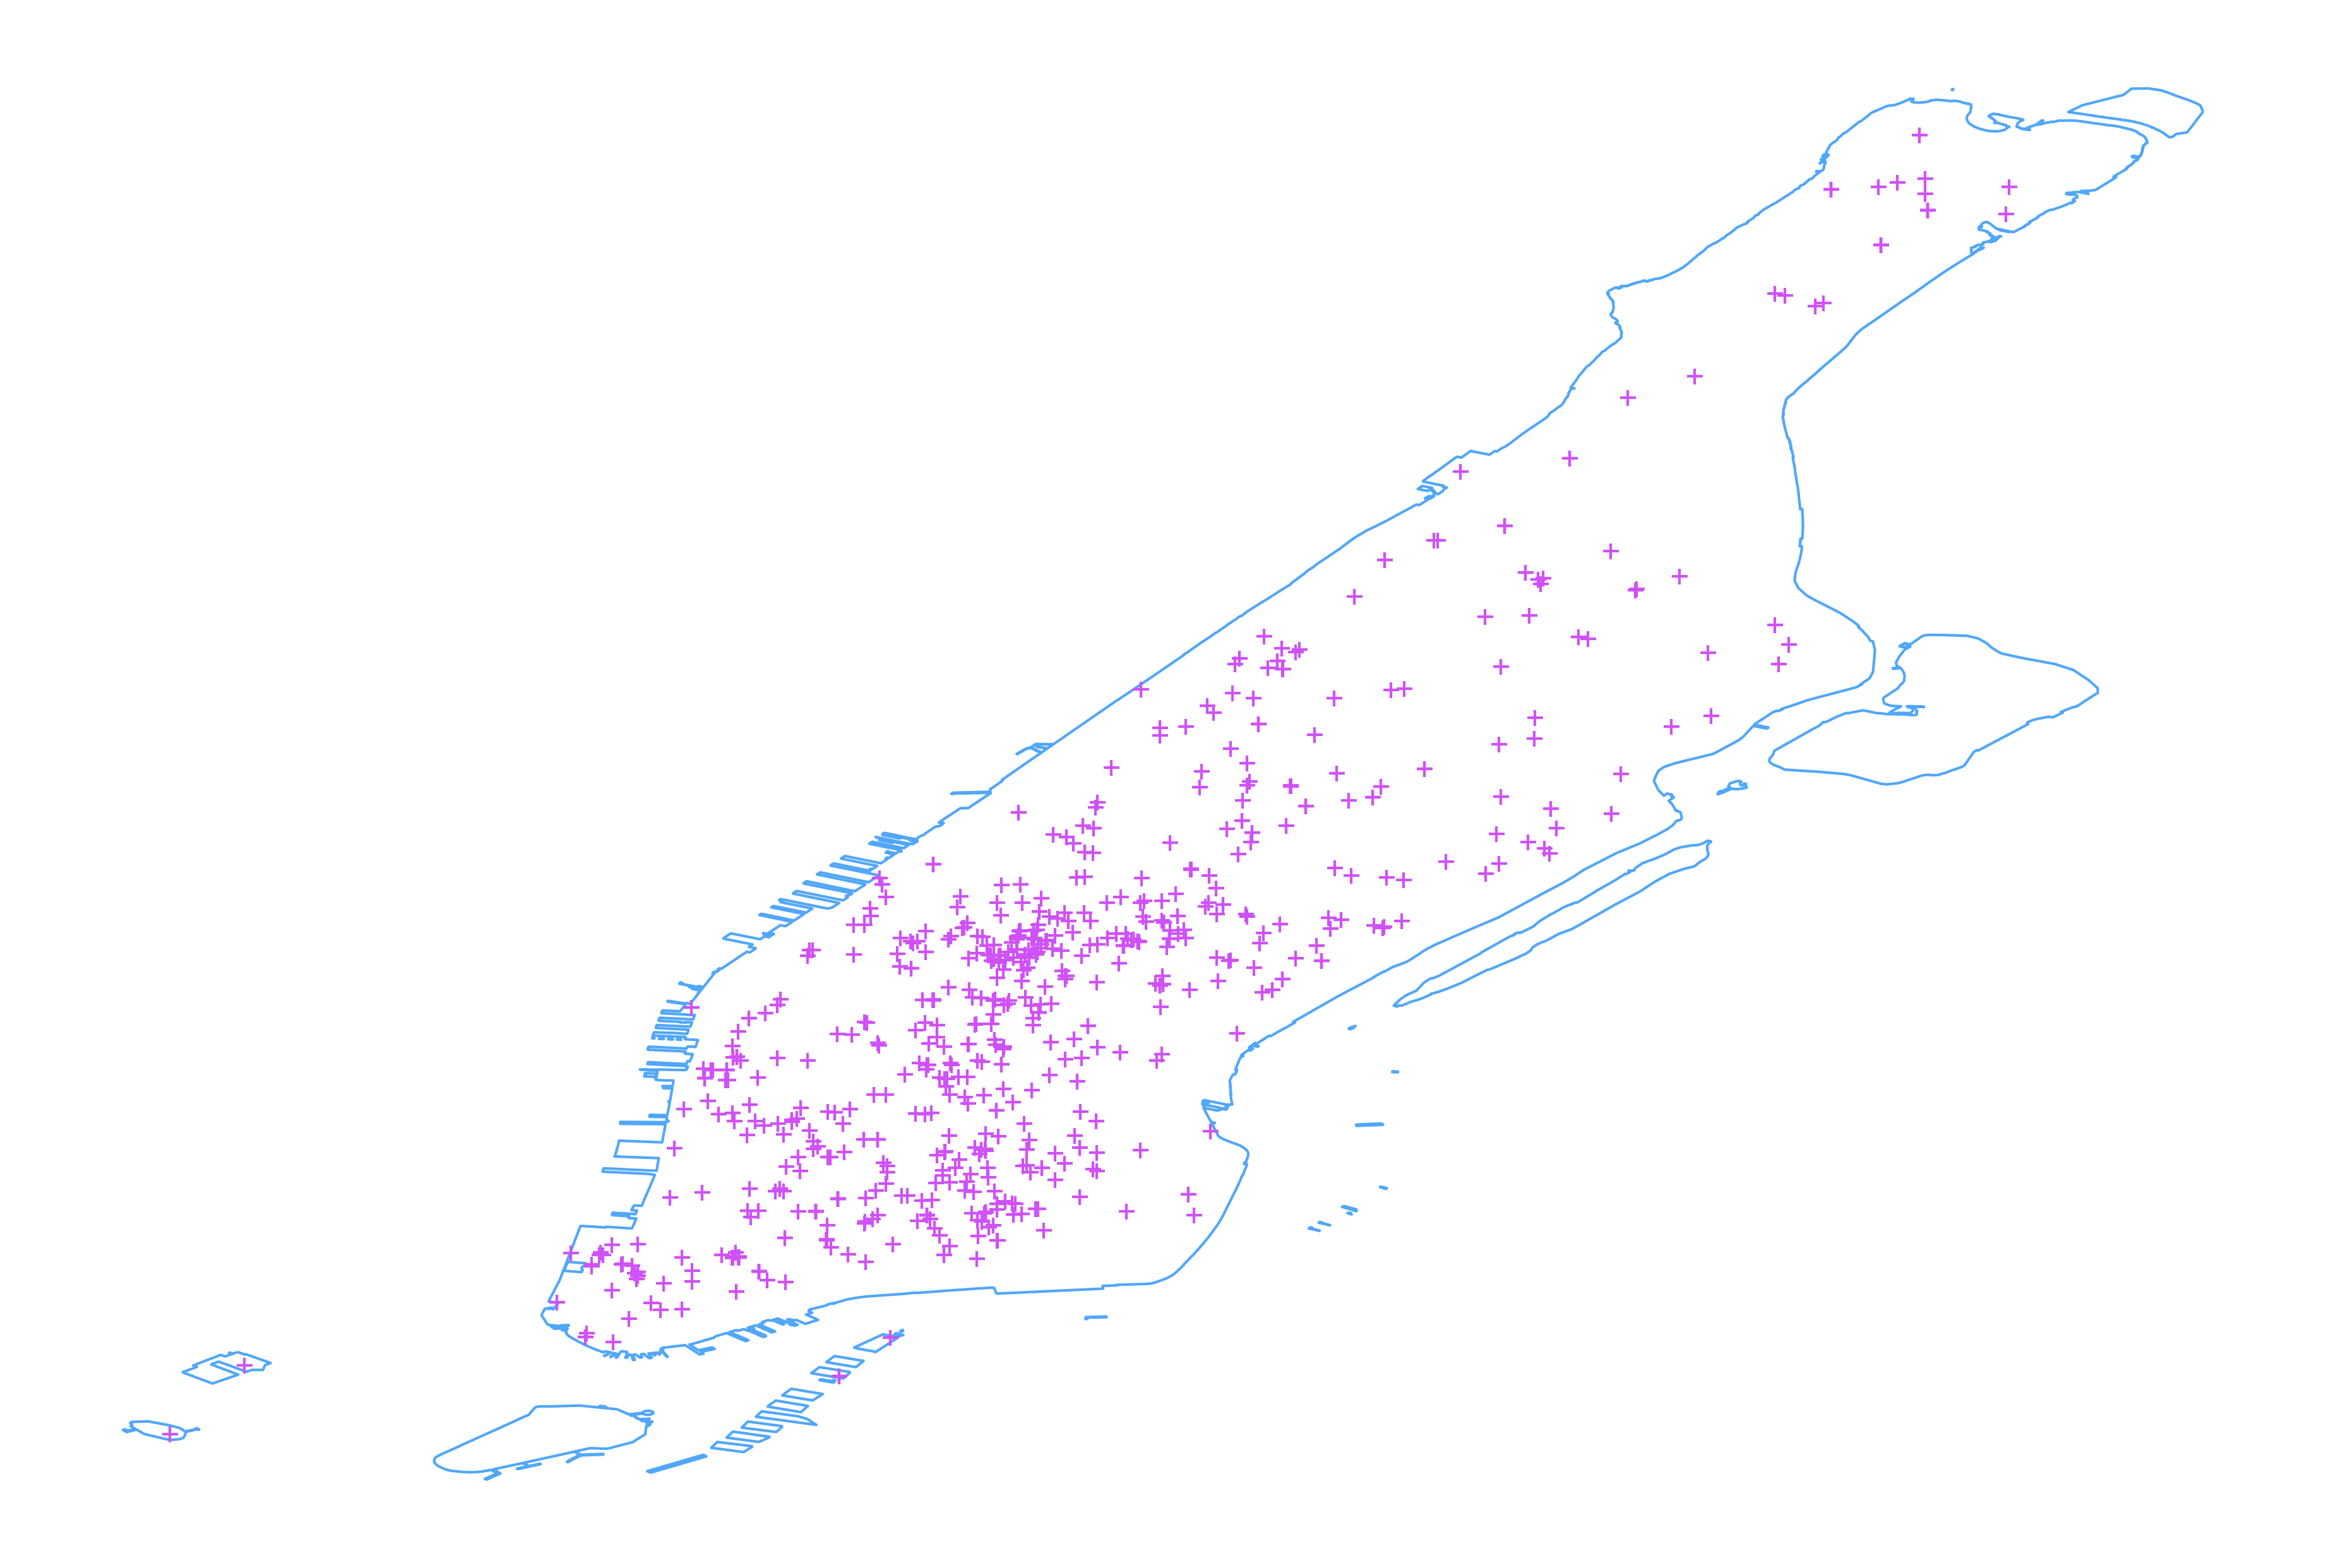

In [33]:
for i in range(len(parts)-1):
	plt.plot(points.T[0][parts[i]:parts[i+1]], points.T[1][parts[i]:parts[i+1]], '-', c=colors[0], lw=1)

plt.plot(tweets['X'], tweets['Y'], '+', c=colors[1])
plt.axis('off')

## Population matrix

Another common format for data is what is known as "raster" file. These are essentially matricies of numbers along with some metadata. Let's take a look at the US population in 2015 according to Columbia's Gridded Population of the World project https://sedac.ciesin.columbia.edu/data/collection/gpw-v4

In [34]:
data = np.loadtxt('data/US_pop.mat')

As you can see this is just a matrix of numbers. nan's are used to denote missing data

In [35]:
data.shape

(119, 246)

In [36]:
data[50,:]

array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan, 1.43647803e+03,
       9.37134521e+02, 7.71265198e+02, 7.78246277e+02, 7.79848511e+02,
       3.08748901e+03, 2.14585605e+04, 4.40342695e+04, 3.14356094e+04,
       4.37279590e+03, 1.89785803e+03, 6.52430420e+03, 1.37475195e+03,
       1.79528894e+03, 1.61386096e+03, 1.17168201e+03, 1.01398602e+03,
       9.70716187e+02, 2.07381699e+02, 1.24349003e+01, 6.72574186e+00,
       2.57071710e+00, 1.25912104e+01, 1.28034401e+01, 1.30428400e+01,
       2.85179405e+01, 2.97565594e+01, 2.97565594e+01, 5.72180710e+01,
       1.06223701e+02, 1.02709297e+02, 9.62921829e+01, 1.12264000e+02,
       1.12264000e+02, 1.12264000e+02, 1.12264000e+02, 1.12264000e+02,
       1.12264000e+02, 1.18276497e+02, 1.45015793e+02, 1.45103897e+02,
       1.45133194e+02, 1.45294296e+02, 1.45463104e+02, 1.90916702e+02,
      

We can get a quick and dirty plot using imshow

In [37]:
data[data>0].max()

3825095.0

(-0.5, 245.5, 118.5, -0.5)

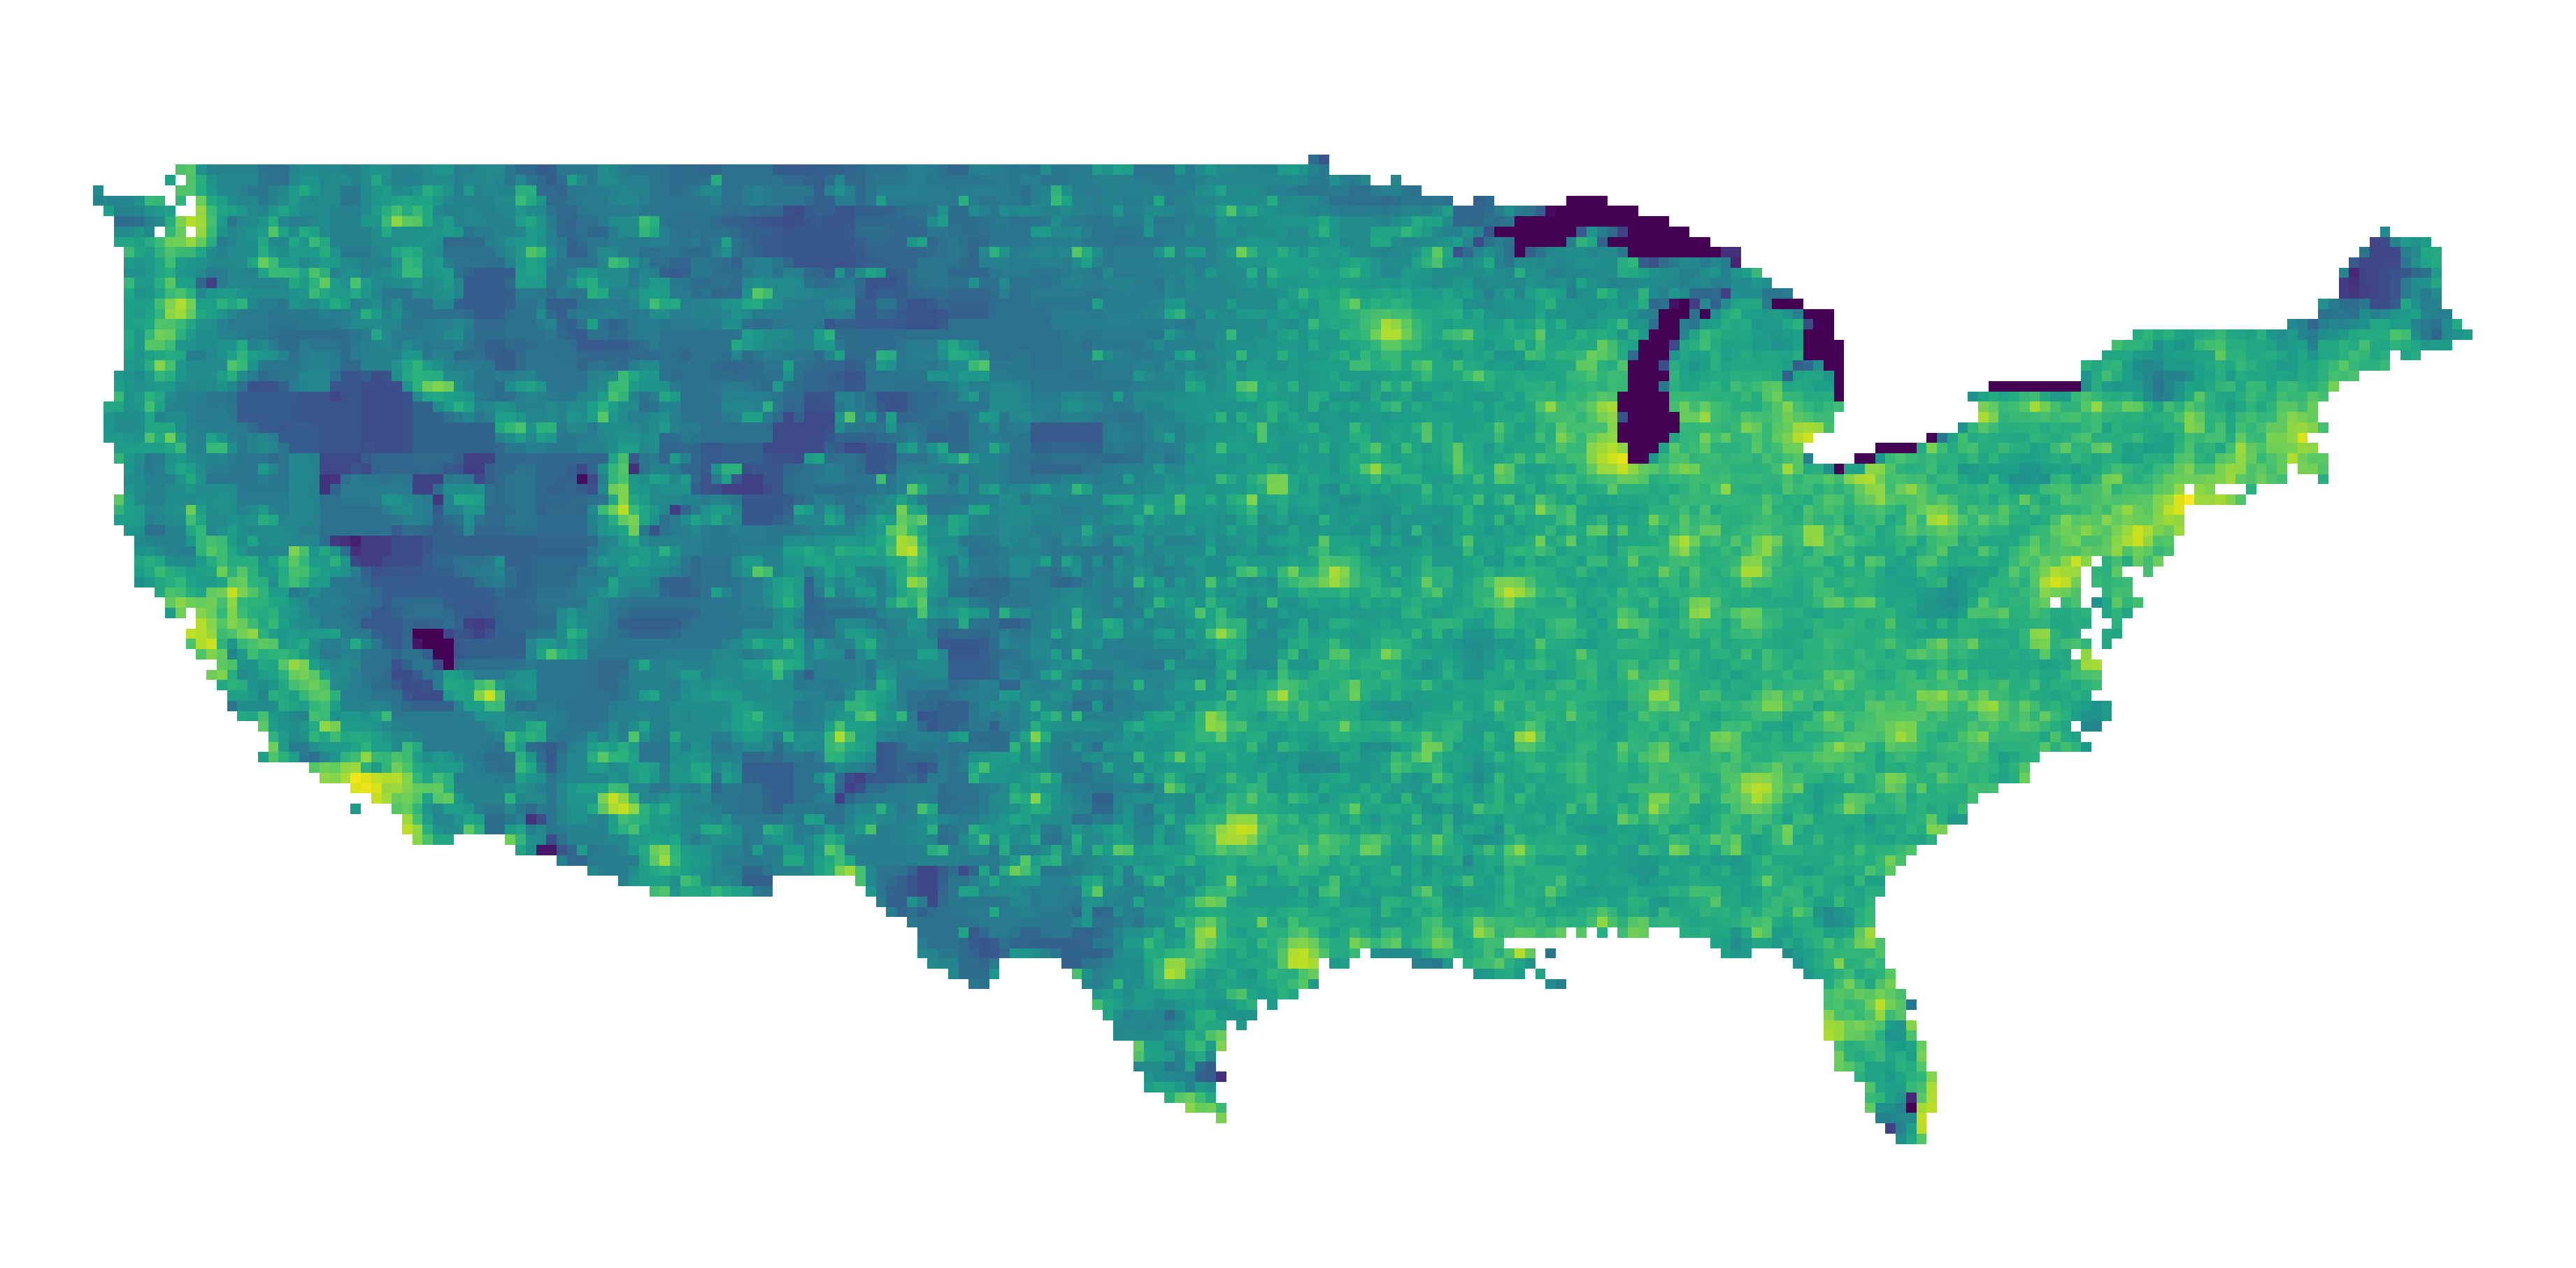

In [38]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.log(data+1))
ax.axis('off')

In addition to this data, we also need the coordinates of the lower left hand corner and the cell size

In [39]:
xllcorner = -126.5
yllcorner = 22.75
cellsize = 0.25

Using this metadata we can now convert between raw lat/lon and matrix coordinates

In [40]:
def map_points(xllcorner, yllcorner, cellsize, nrows, x, y):
    x = int((x-xllcorner)/cellsize)
    y = (nrows-1)-int((y-yllcorner)/cellsize)

    return x, y

Which is useful when we want to add point or lines to the plot

(-0.5, 245.5, 118.5, -0.5)

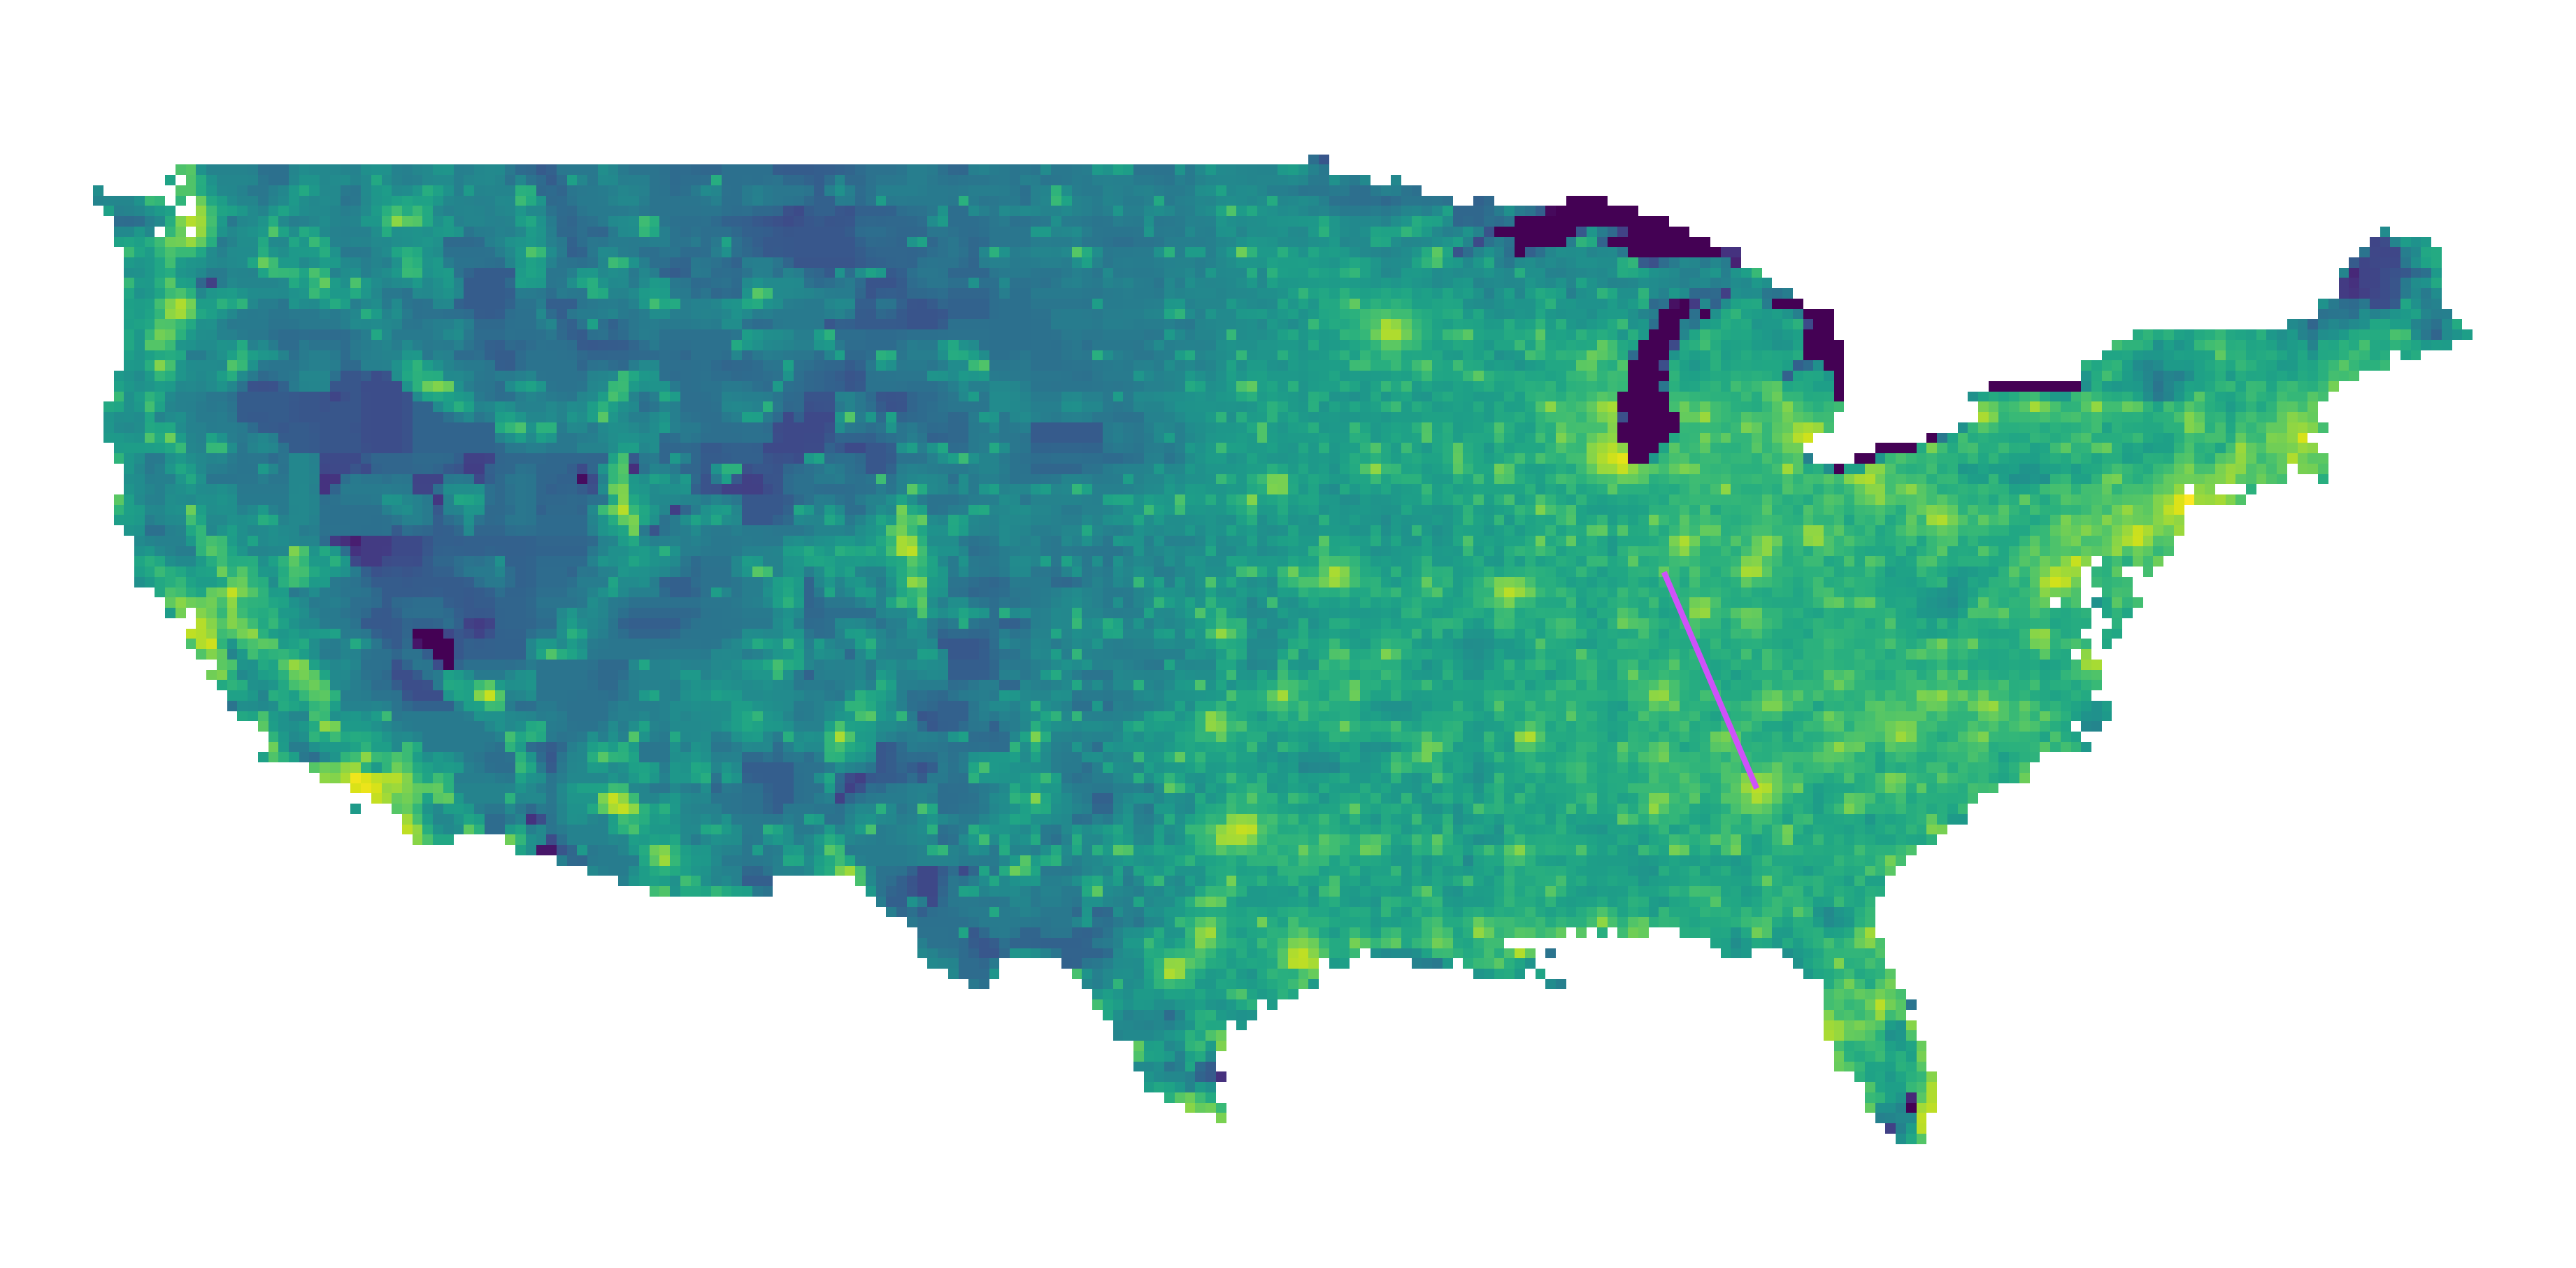

In [41]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.log(data+1))

x1, y1 = map_points(xllcorner, yllcorner, cellsize, data.shape[0], -86.523435, 39.163355, )
x2, y2 = map_points(xllcorner, yllcorner, cellsize, data.shape[0], -84.404820, 33.761926, )

ax.plot([x1, x2], [y1, y2], '-', c=colors[1], lw=2)
ax.axis('off')

Add all the state boundaries https://www.usgs.gov/products/data-and-tools/gis-data in the same slightly massaged format as the Manhattan data above

(-0.5, 245.5, 118.5, -0.5)

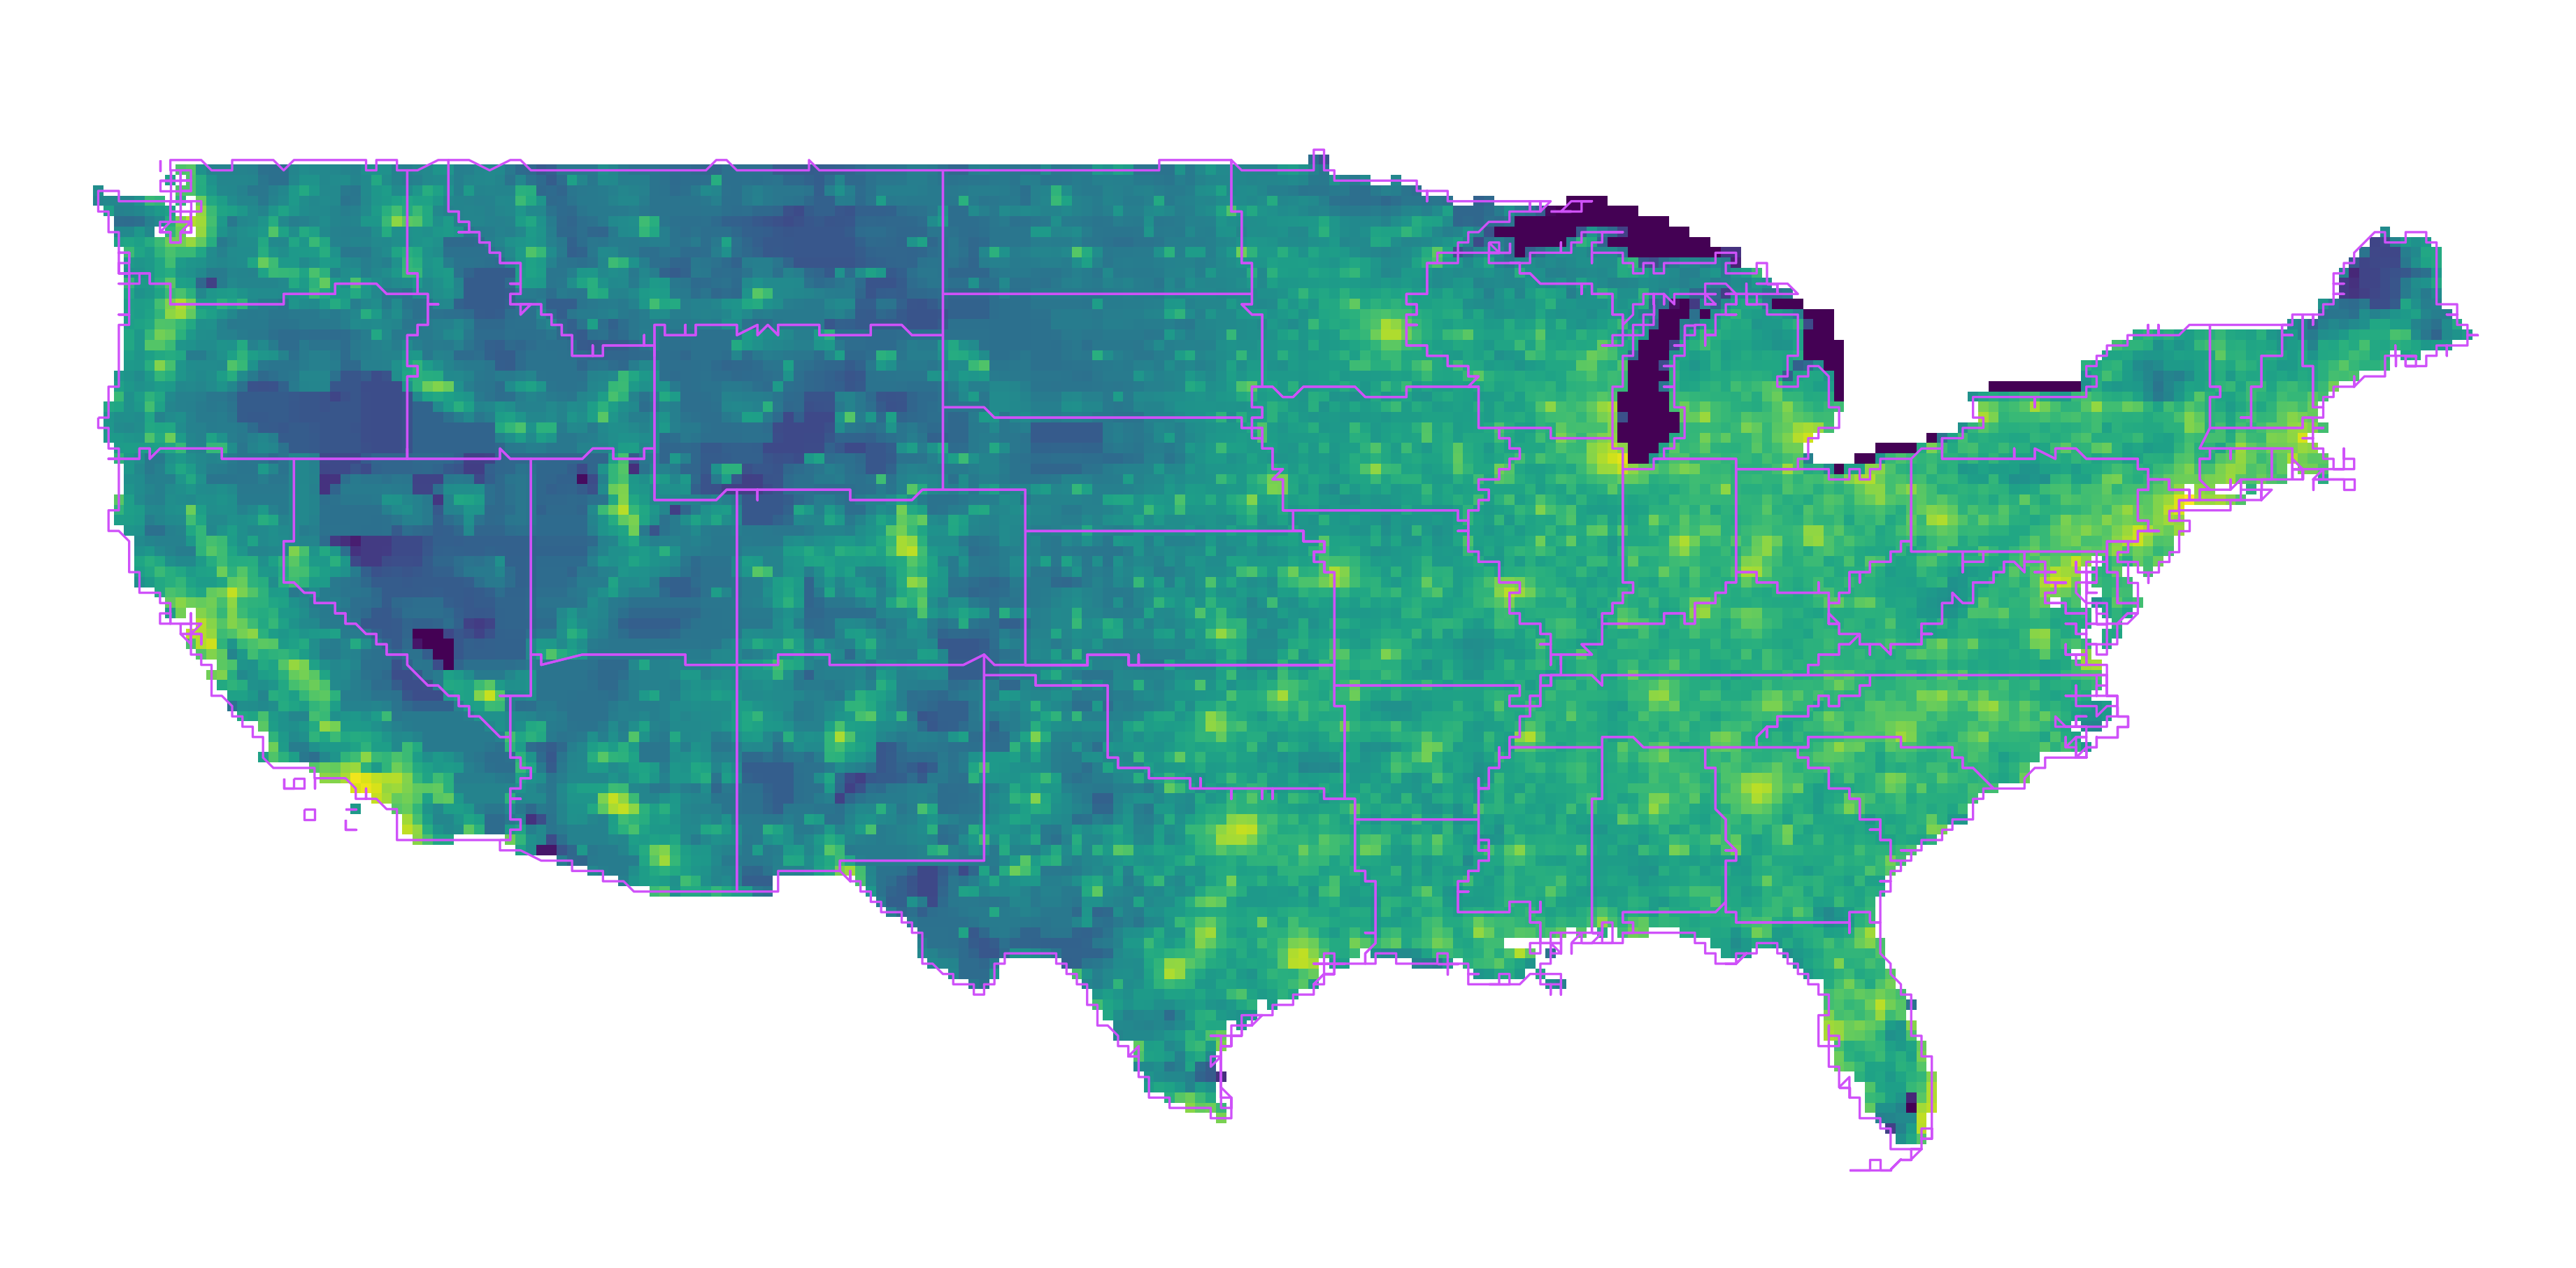

In [42]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.log(data+1))

shapes = json.loads(open("data/48states.json", "rt").readline())

pos = None
count = 0

for shape in shapes:
        points = np.array(shape["points"])
        parts = shape["parts"]

        for i in range(len(parts)-1):
            positions = []

            for j in range(parts[i+1]-parts[i]):
                x_orig = points.T[0][parts[i]+j]
                y_orig = points.T[1][parts[i]+j]
                x, y = map_points(xllcorner, yllcorner, cellsize, data.shape[0], x_orig, y_orig)
                positions.append([x, y])
            
            positions = np.array(positions)

            ax.plot(positions.T[0], positions.T[1], '-', c=colors[1], lw=0.8)

ax.axis('off')

## Data aggregation

The main advantage of being able to easily disply matricies of data is that you can aggregate geographical data into a matrix to plotting.

Define the constants needed to convert between matrix coordinates to lat/lon

In [43]:
xllcorner = -74.0477296269704
yllcorner = 40.68291694544512
xurcorner = -73.9066509953948
yurcorner = 40.87903804730722
cellsize = 0.001

Build a matrix that counts how many tweets occurred in each cell of Manhattan

In [44]:
ncols = int((xurcorner-xllcorner)/cellsize)
nrows = int((yurcorner-yllcorner)/cellsize)

data = np.zeros((nrows, ncols), dtype='int')#*np.nan

for tweet_id in range(tweets.shape[0]):
    try:
        coordinates = tweets.iloc[tweet_id]
                    
        coord_x, coord_y = map_points(xllcorner, yllcorner, cellsize, nrows, coordinates[0], coordinates[1])
        
        value = data[coord_y, coord_x]
        
        #if np.isnan(value):
        #    data[coord_y, coord_x] = 1
        #else:
        data[coord_y, coord_x] += 1
    except:
        pass
    


Plot the resulting matrix. It should be noted that in practice there is no difference between this matrix and the population matrix we used above

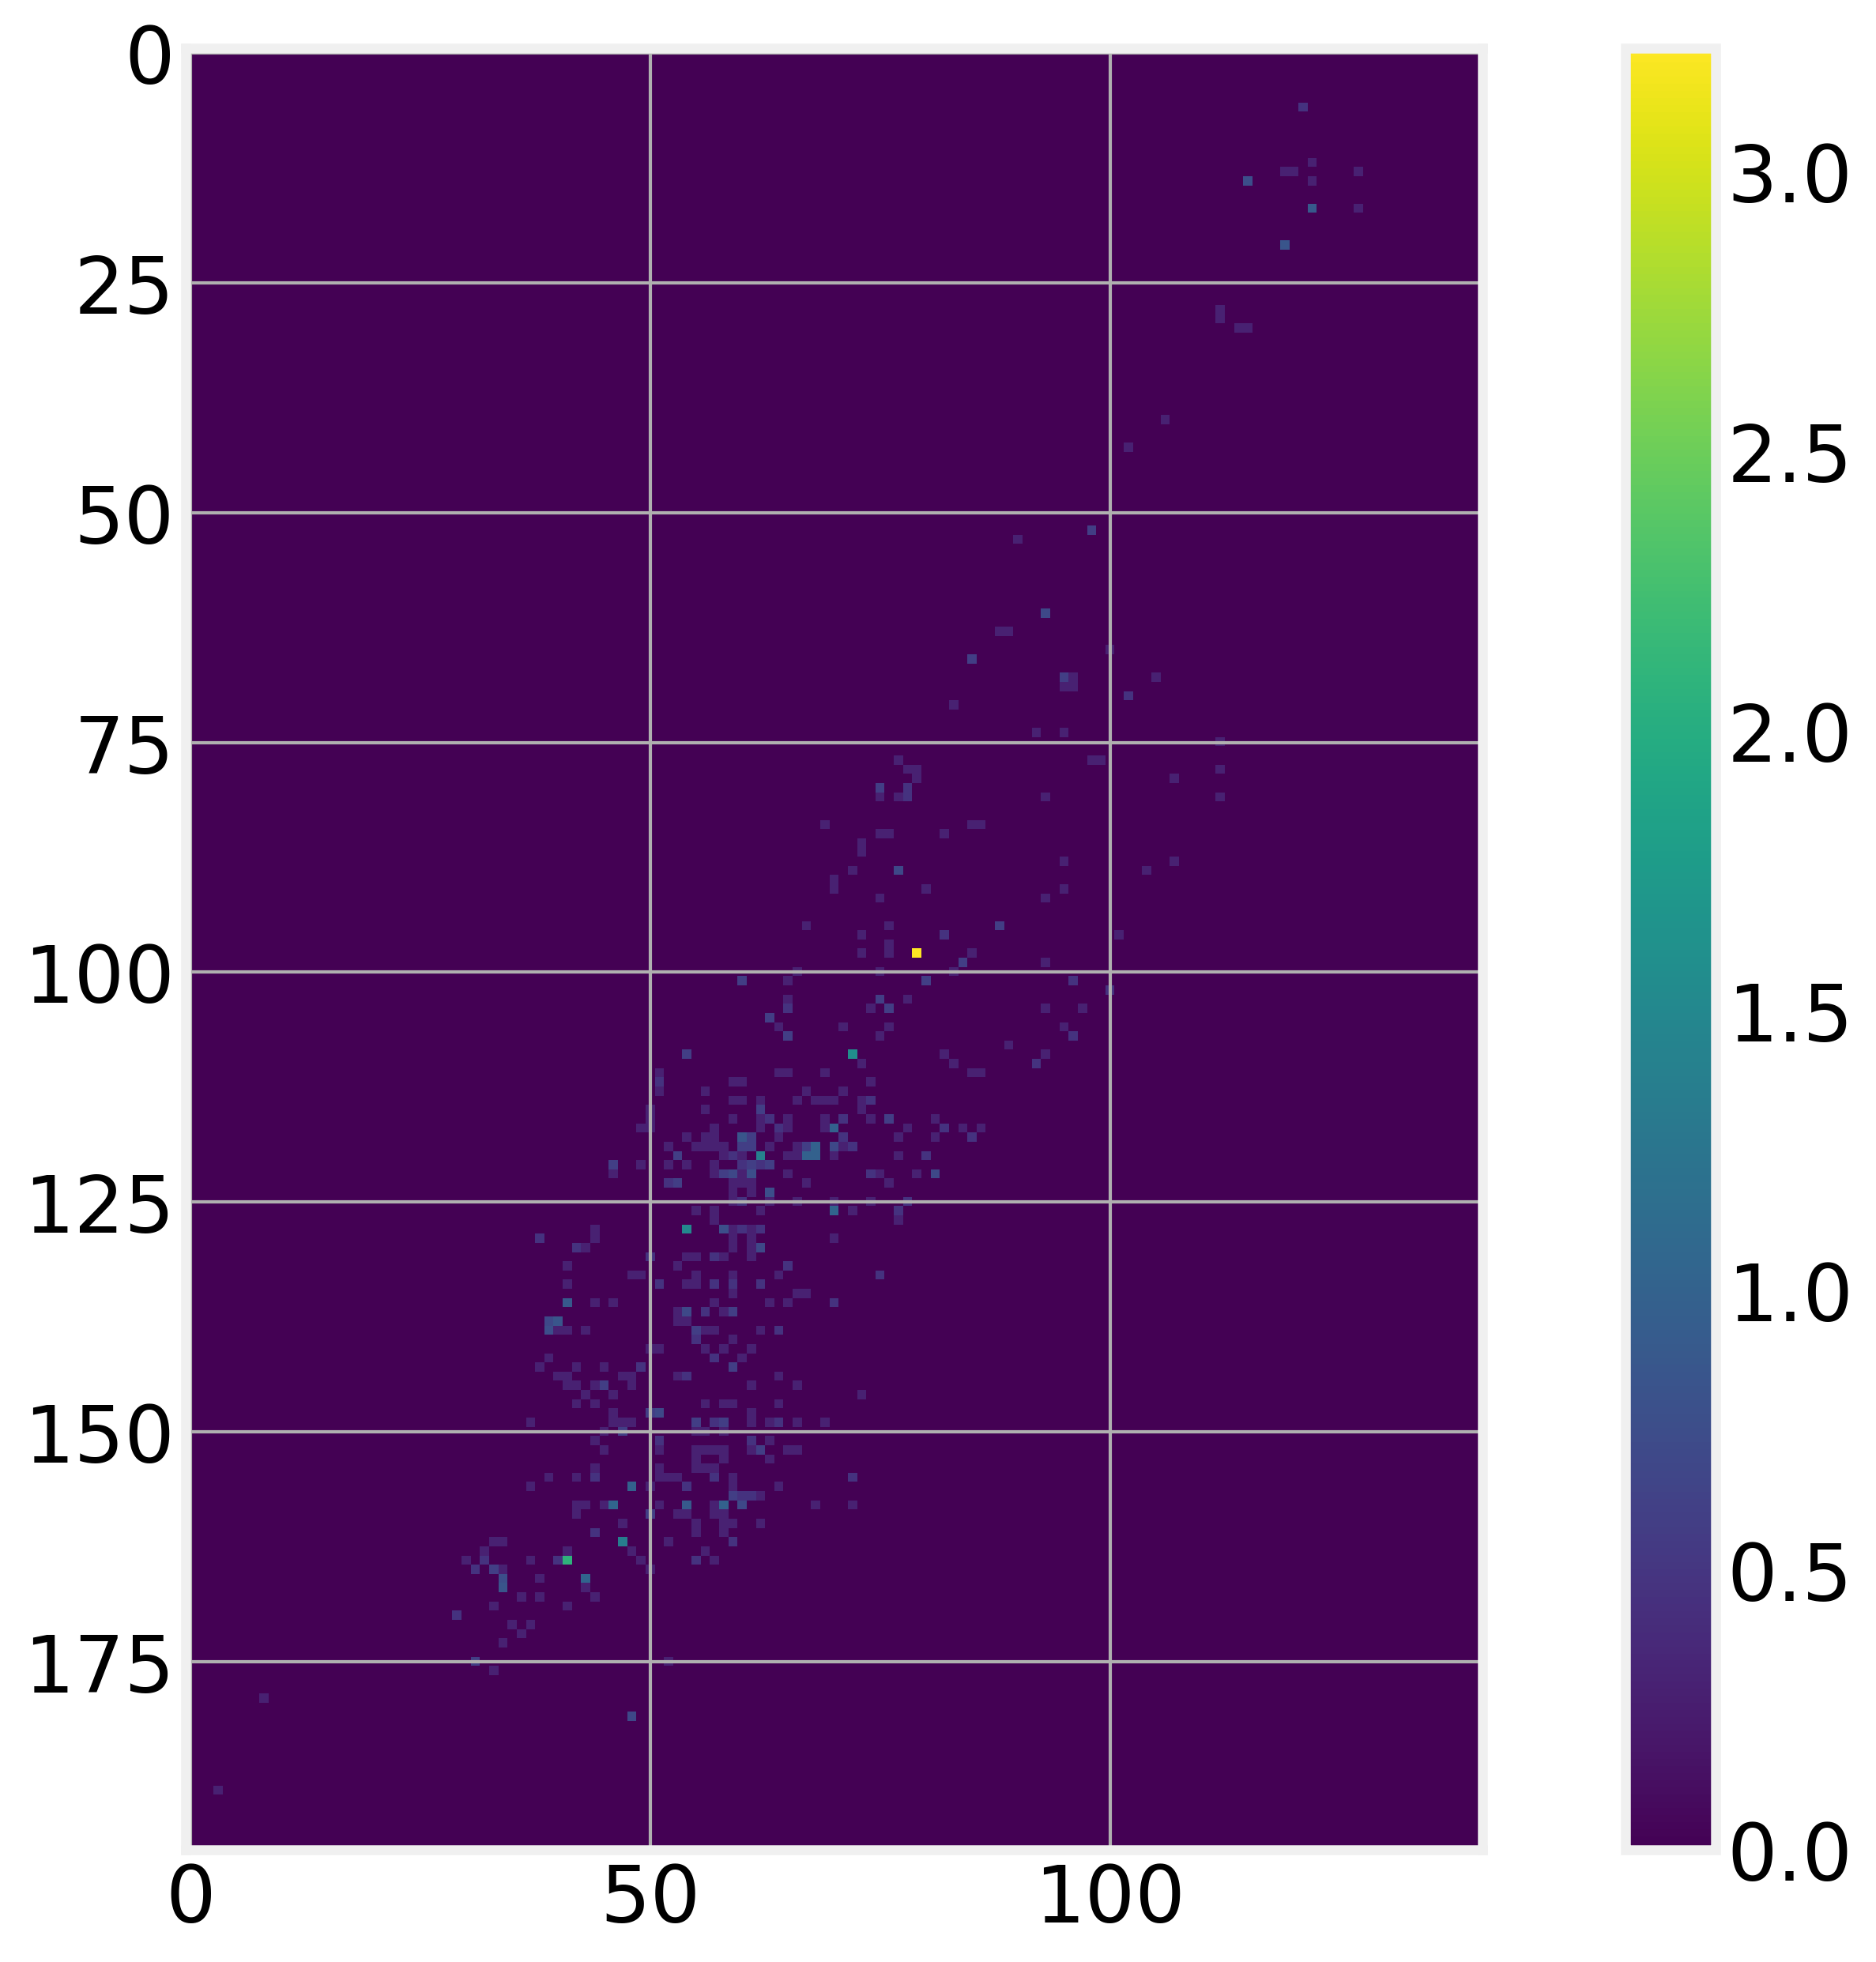

In [45]:
plt.imshow(np.log10(data+1))
plt.colorbar()

Naturally we can also add the boundary information. Reload the data

In [46]:
manhattan = json.loads(open("data/Manhattan.json", "rt").readline())

points = np.array(manhattan["points"])
parts = manhattan["parts"]

Generate the joint plot. Here we use the **extent** parameter to redifine the x,y axis coordinates to be lat and lon. 

(-74.0477296269704, -73.9066509953948, 40.68291694544512, 40.87903804730722)

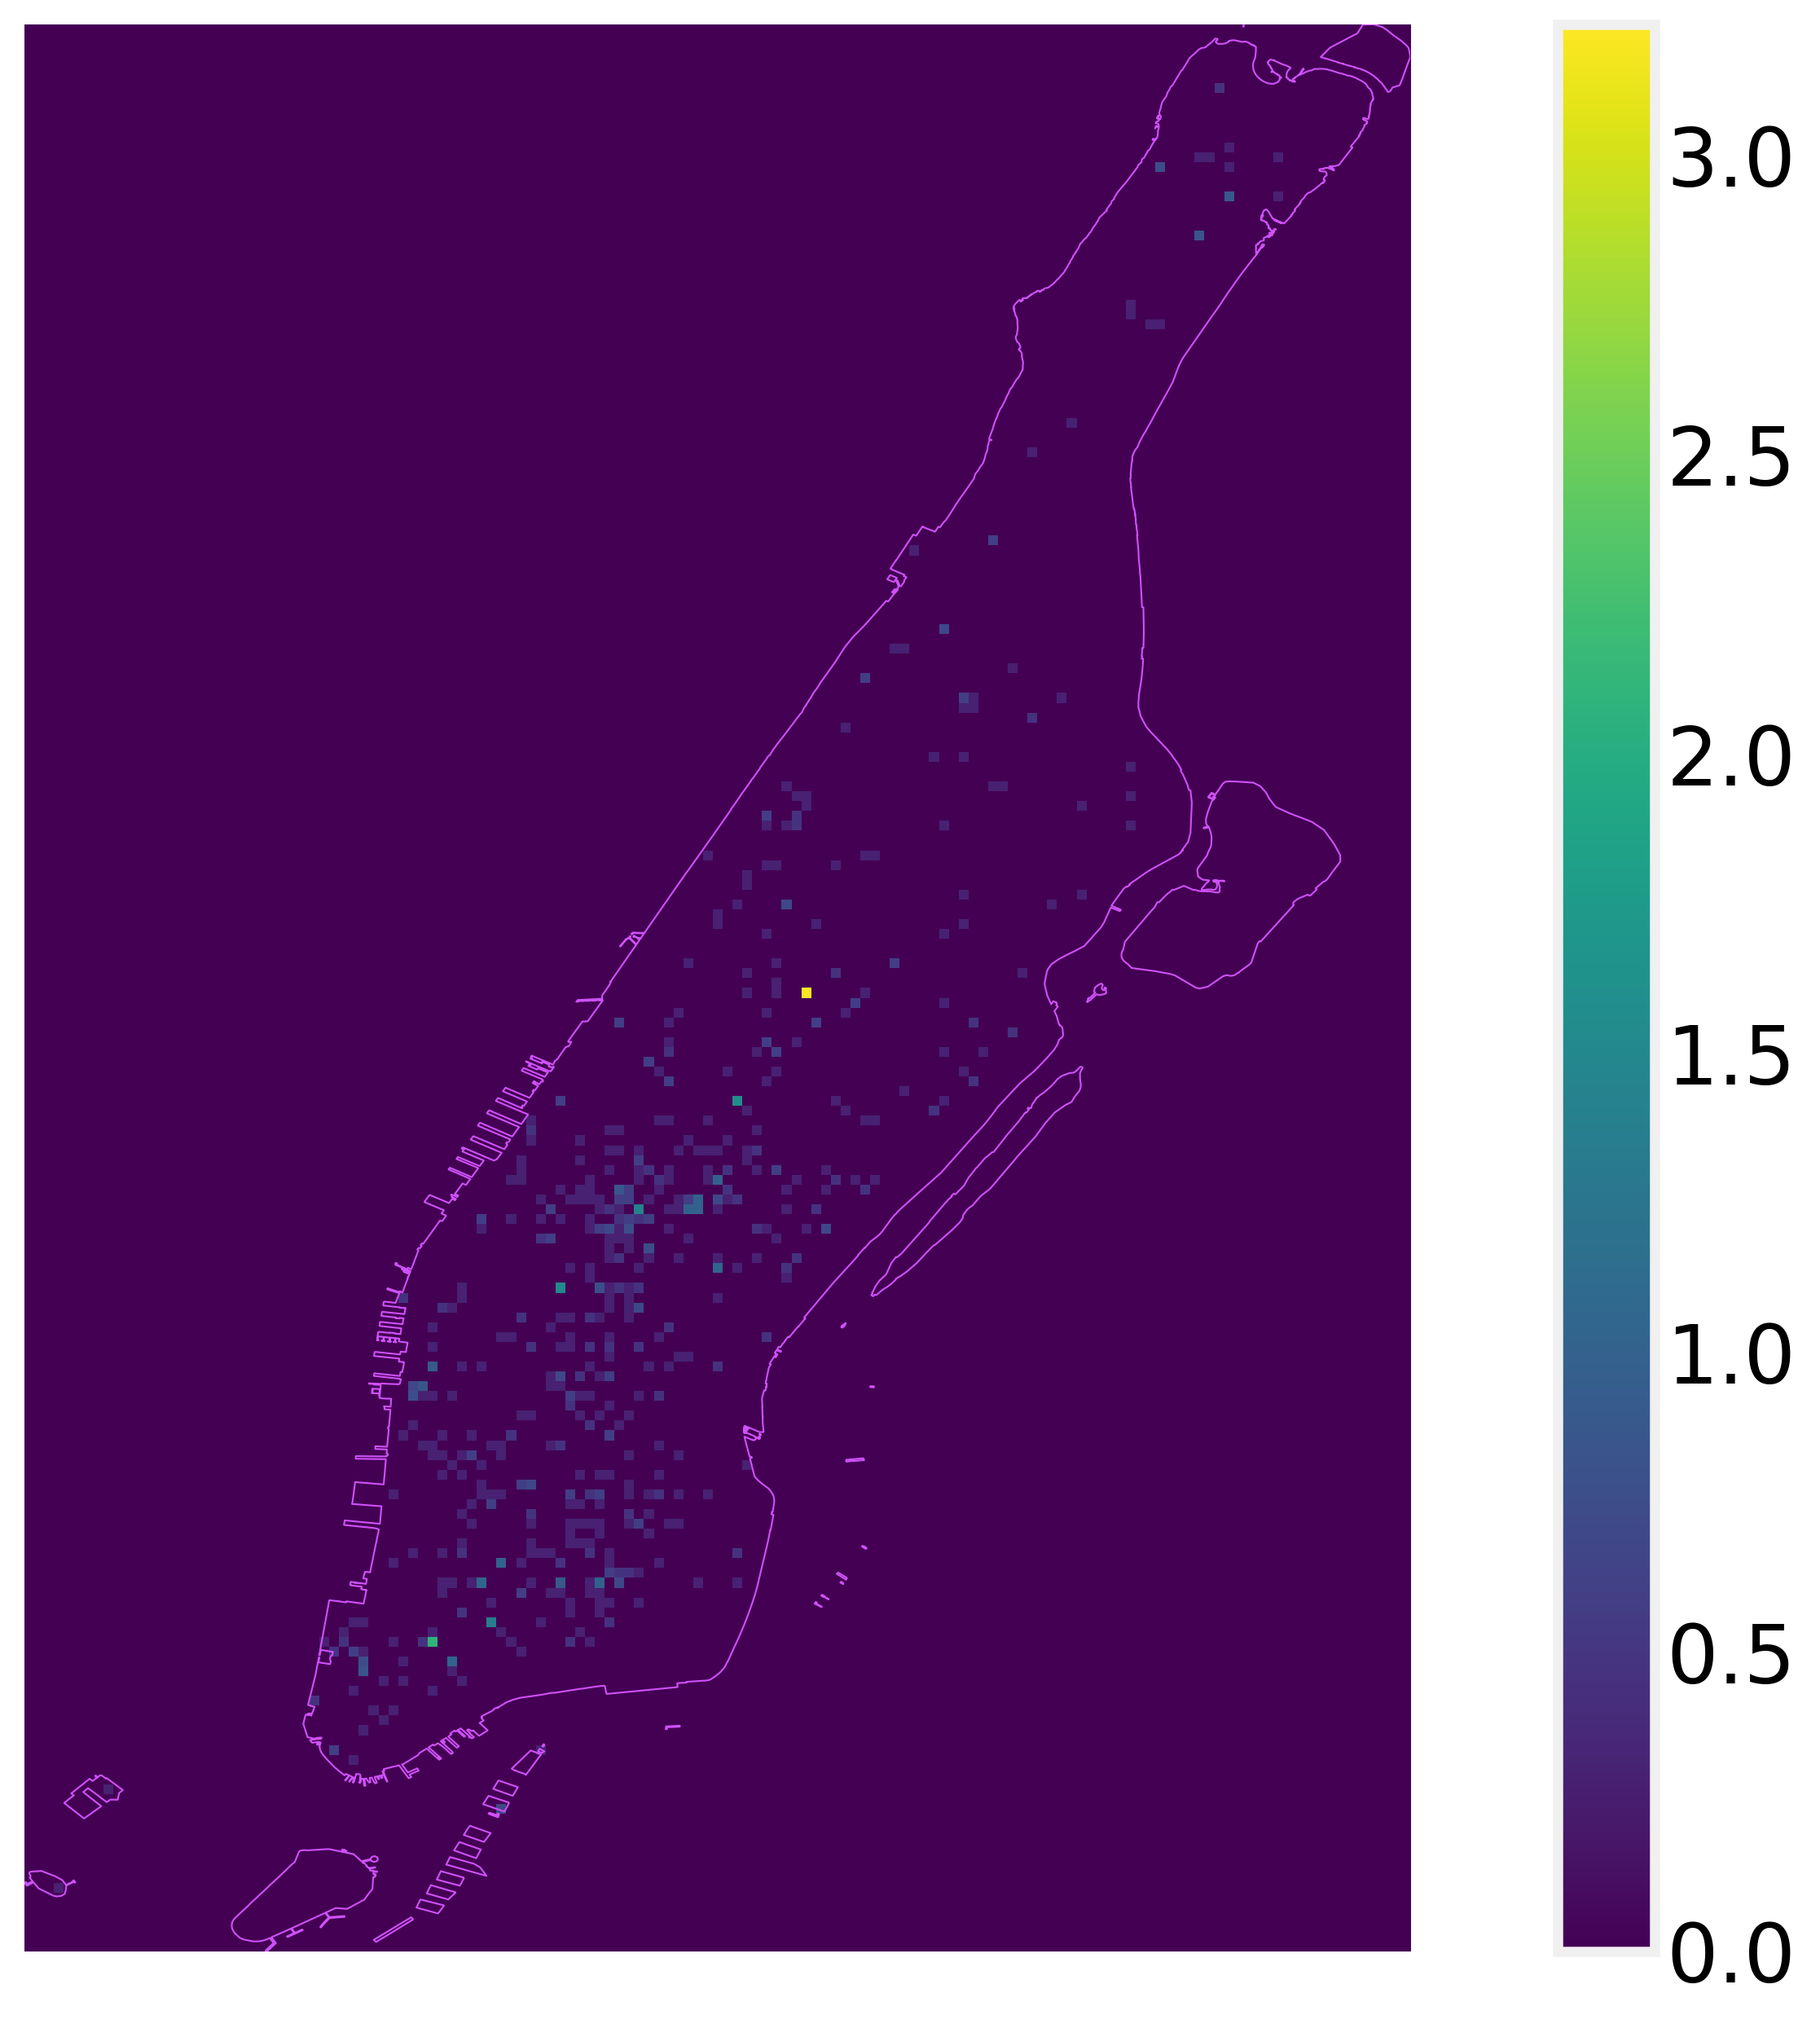

In [47]:
plt.imshow(np.log10(data+1), extent=(xllcorner, xurcorner, yllcorner, yurcorner))

for i in range(len(parts)-1):
	plt.plot(points.T[0][parts[i]:parts[i+1]], points.T[1][parts[i]:parts[i+1]], '-', c=colors[1], lw=0.5)

plt.colorbar()
plt.axis('off')

## Basemap

**Basemap** is a **matplotlib** add on package that is built specifically to easily handle the mapping of geographical information. Plotting a minimalistic map of the world takes just a couple of lines.

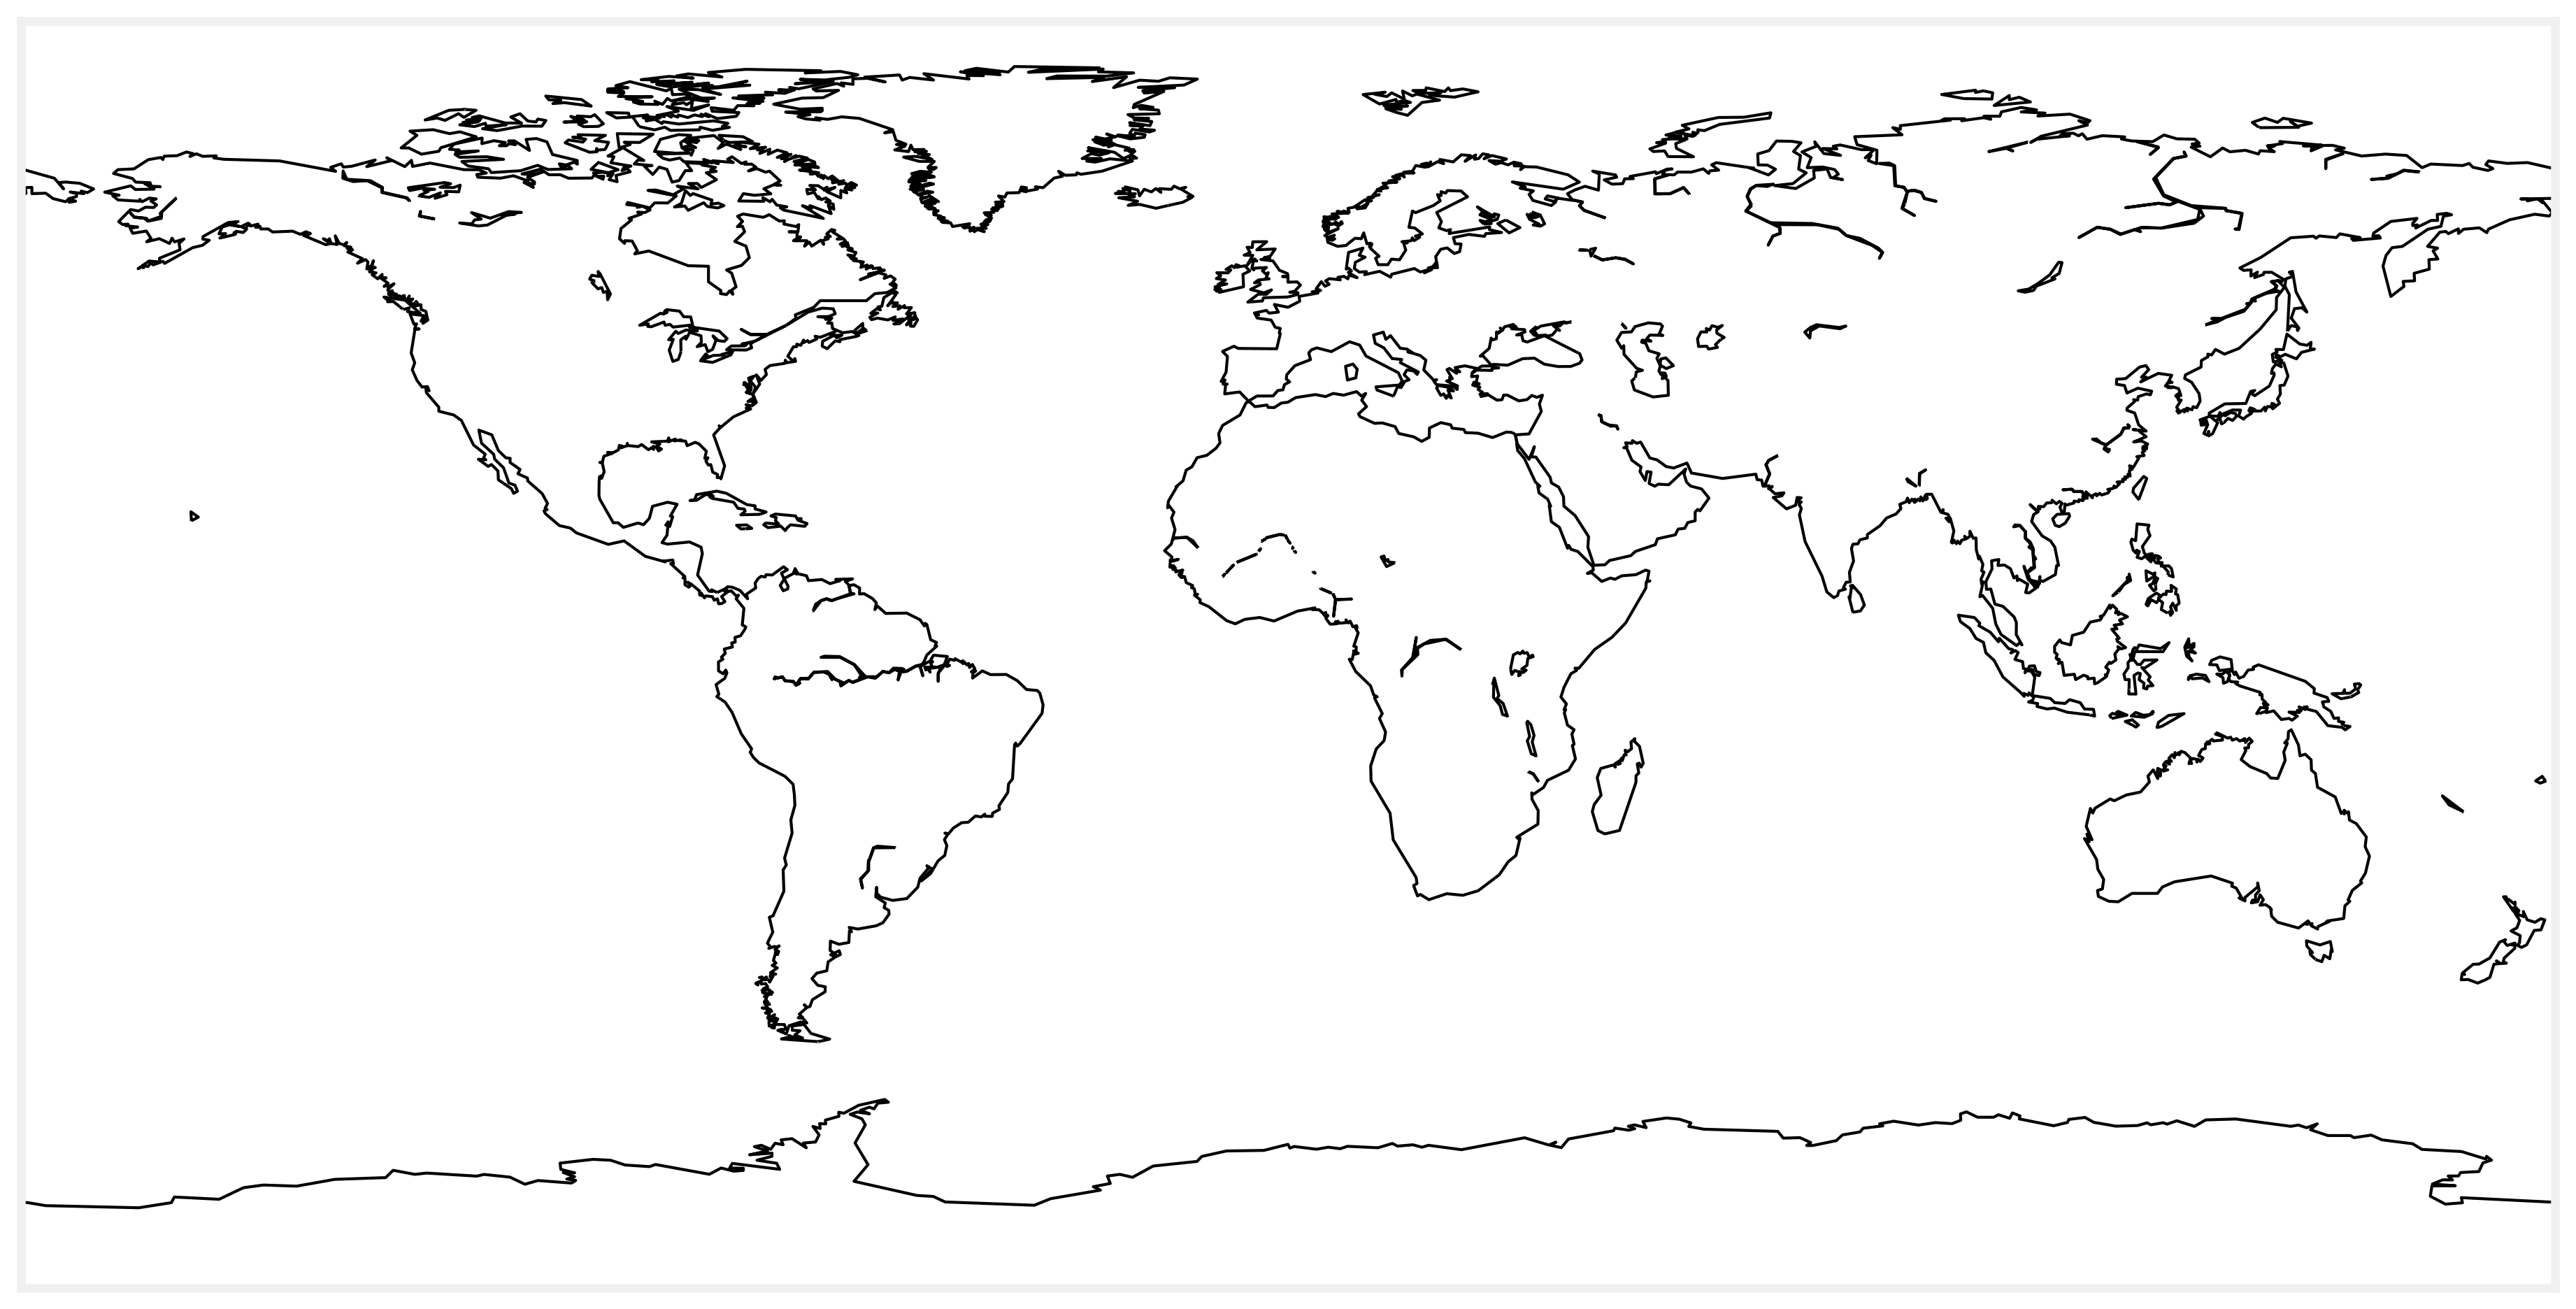

In [48]:
 m = Basemap()
 m.drawcoastlines()

We can also use different projections and select only part of the map

In [49]:
m = Basemap(llcrnrlon=-10.5,llcrnrlat=35,urcrnrlon=4.,urcrnrlat=44.,
             resolution='i', projection='tmerc', lat_0 = 39.5, lon_0 = -3.25)

m.drawmapboundary(fill_color=colors[0])
m.fillcontinents(color=colors[4],lake_color=colors[0])
m.drawcoastlines()

OSError: Unable to open boundary dataset file. Only the 'crude' and  'low',
resolution datasets are installed by default.
If you are requesting an, 'intermediate', 'high' or 'full'
resolution dataset, you may need to download and install those
files separately with
`conda install basemap-data-hires`.

And draw great circles connecting points on the map. This and other examples can be found in the official Basemap documentation https://matplotlib.org/basemap/users/examples.html

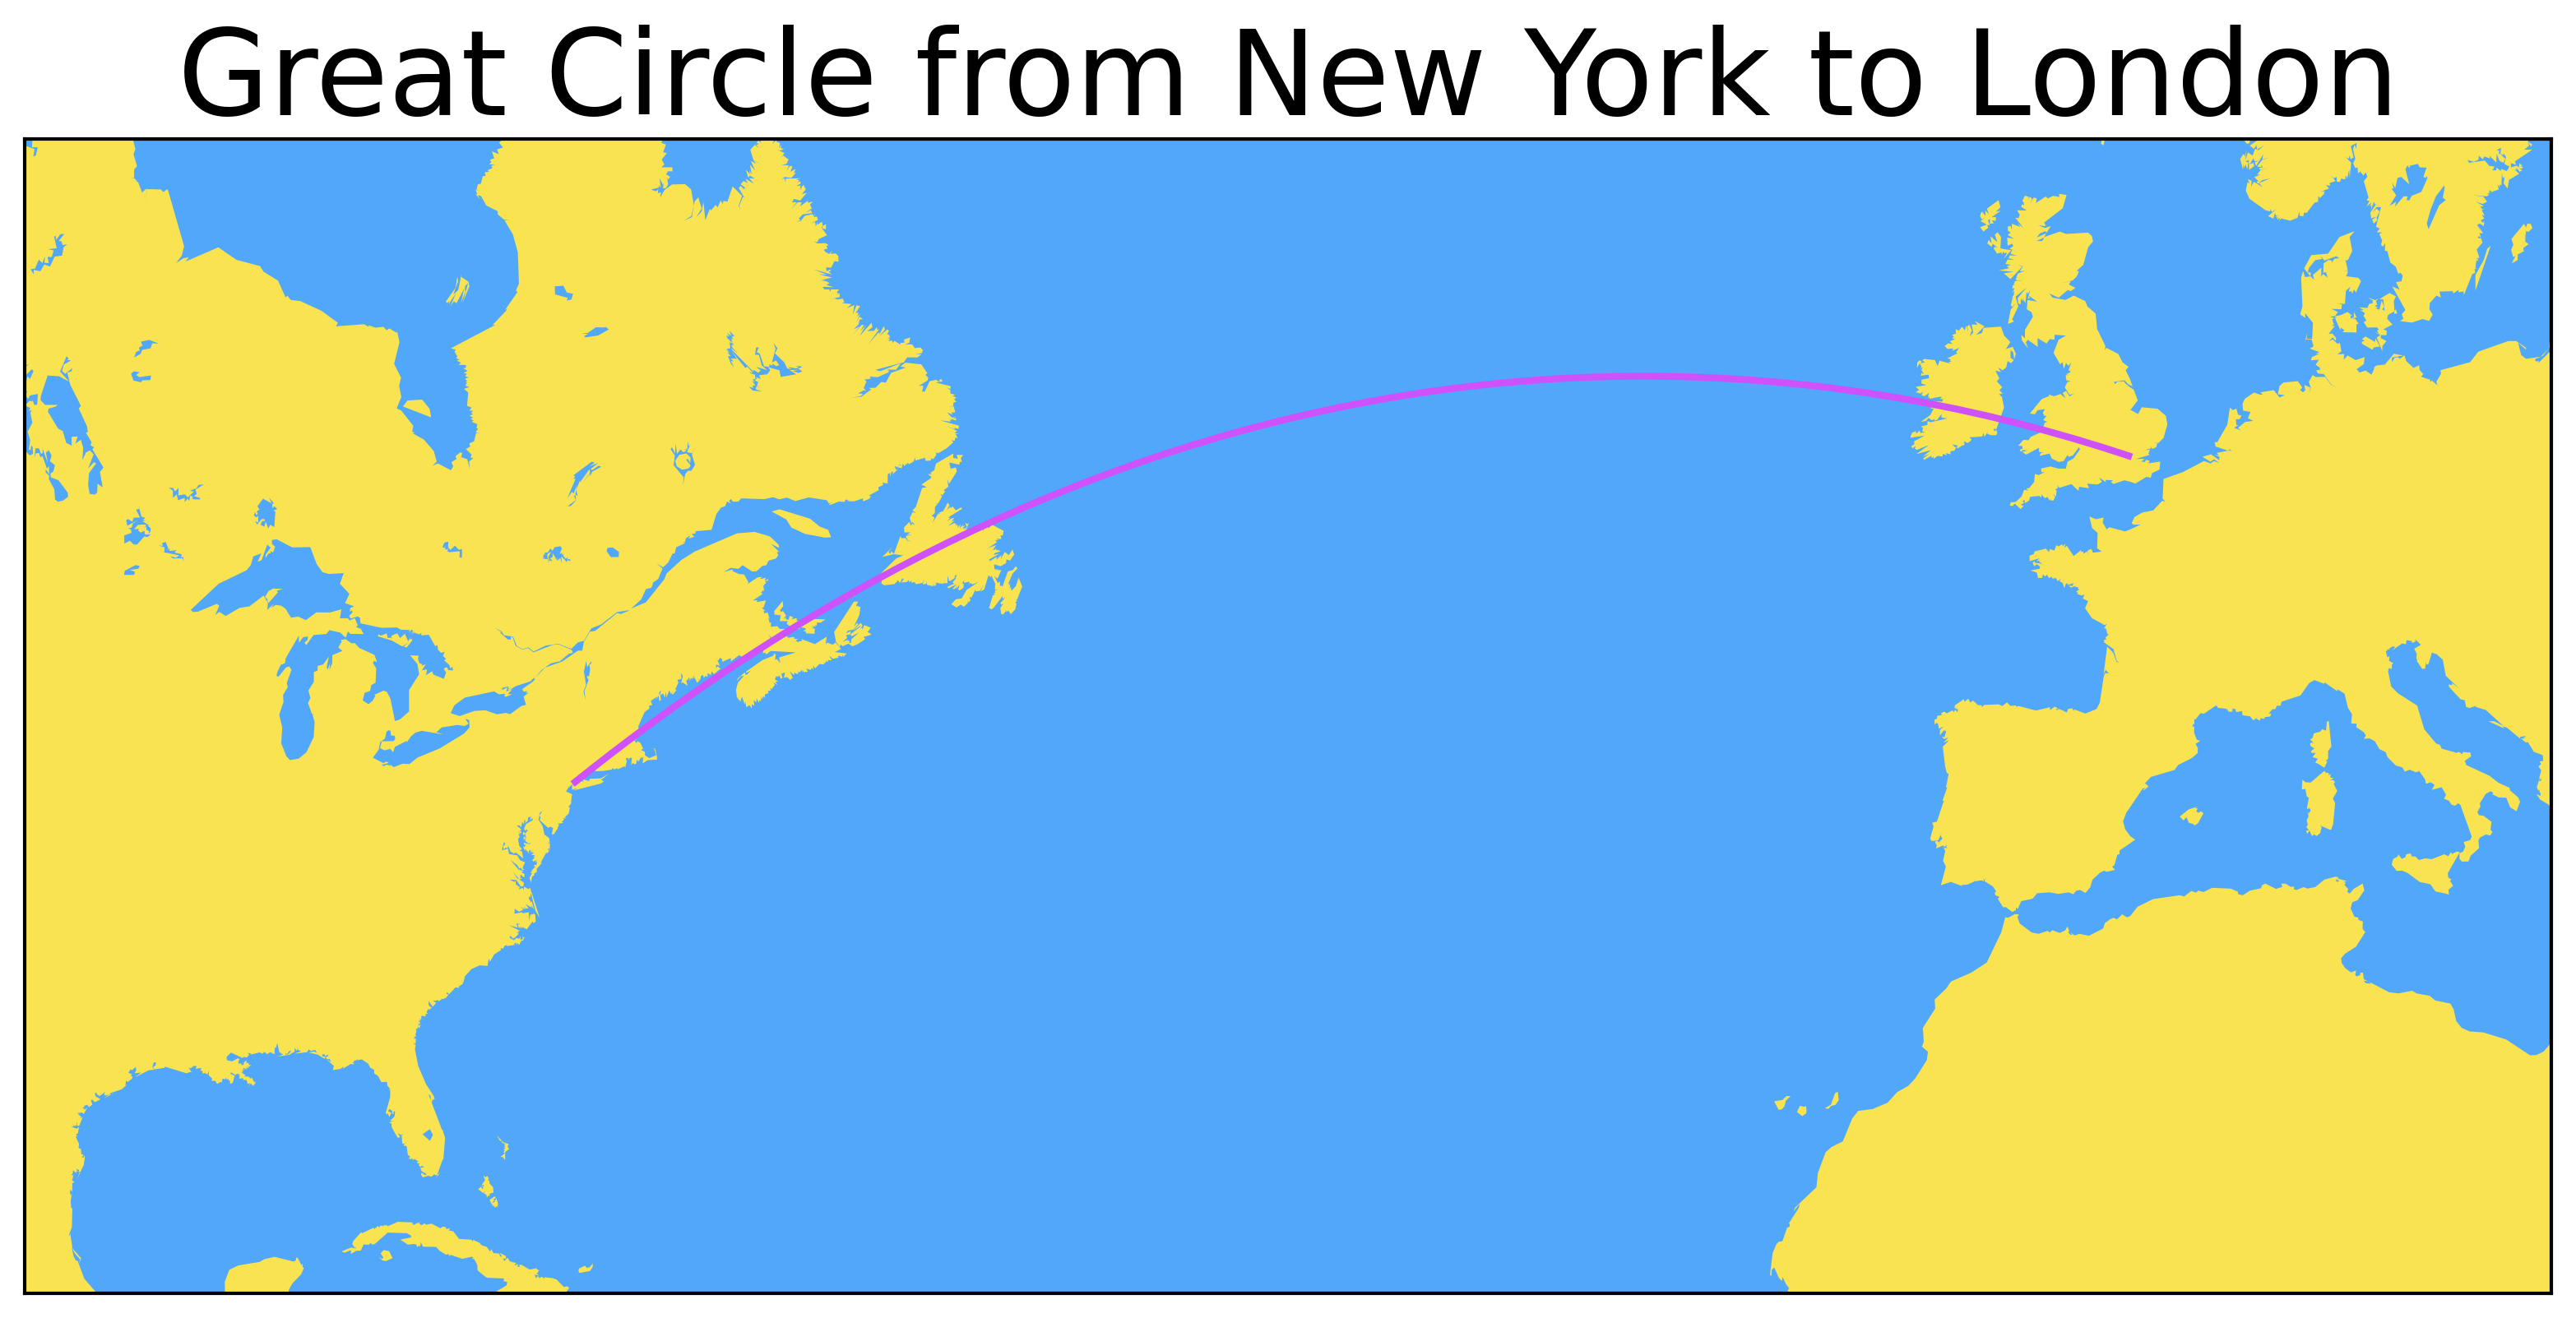

In [50]:
fig=plt.figure()
ax=fig.add_axes([0.1,0.1,0.8,0.8])

# setup mercator map projection.
m = Basemap(llcrnrlon=-100.,llcrnrlat=20.,urcrnrlon=20.,urcrnrlat=60.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)

# nylat, nylon are lat/lon of New York
nylat = 40.78; nylon = -73.98

# lonlat, lonlon are lat/lon of London.
lonlat = 51.53; lonlon = 0.08

# draw great circle route between NY and London
m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=2, color=colors[1])
m.drawmapboundary(fill_color=colors[0])
m.fillcontinents(color=colors[4],lake_color=colors[0])
ax.set_title('Great Circle from New York to London');

Easily add parallels and meridians

Text(0.5, 1.0, 'Great Circle from New York to London')

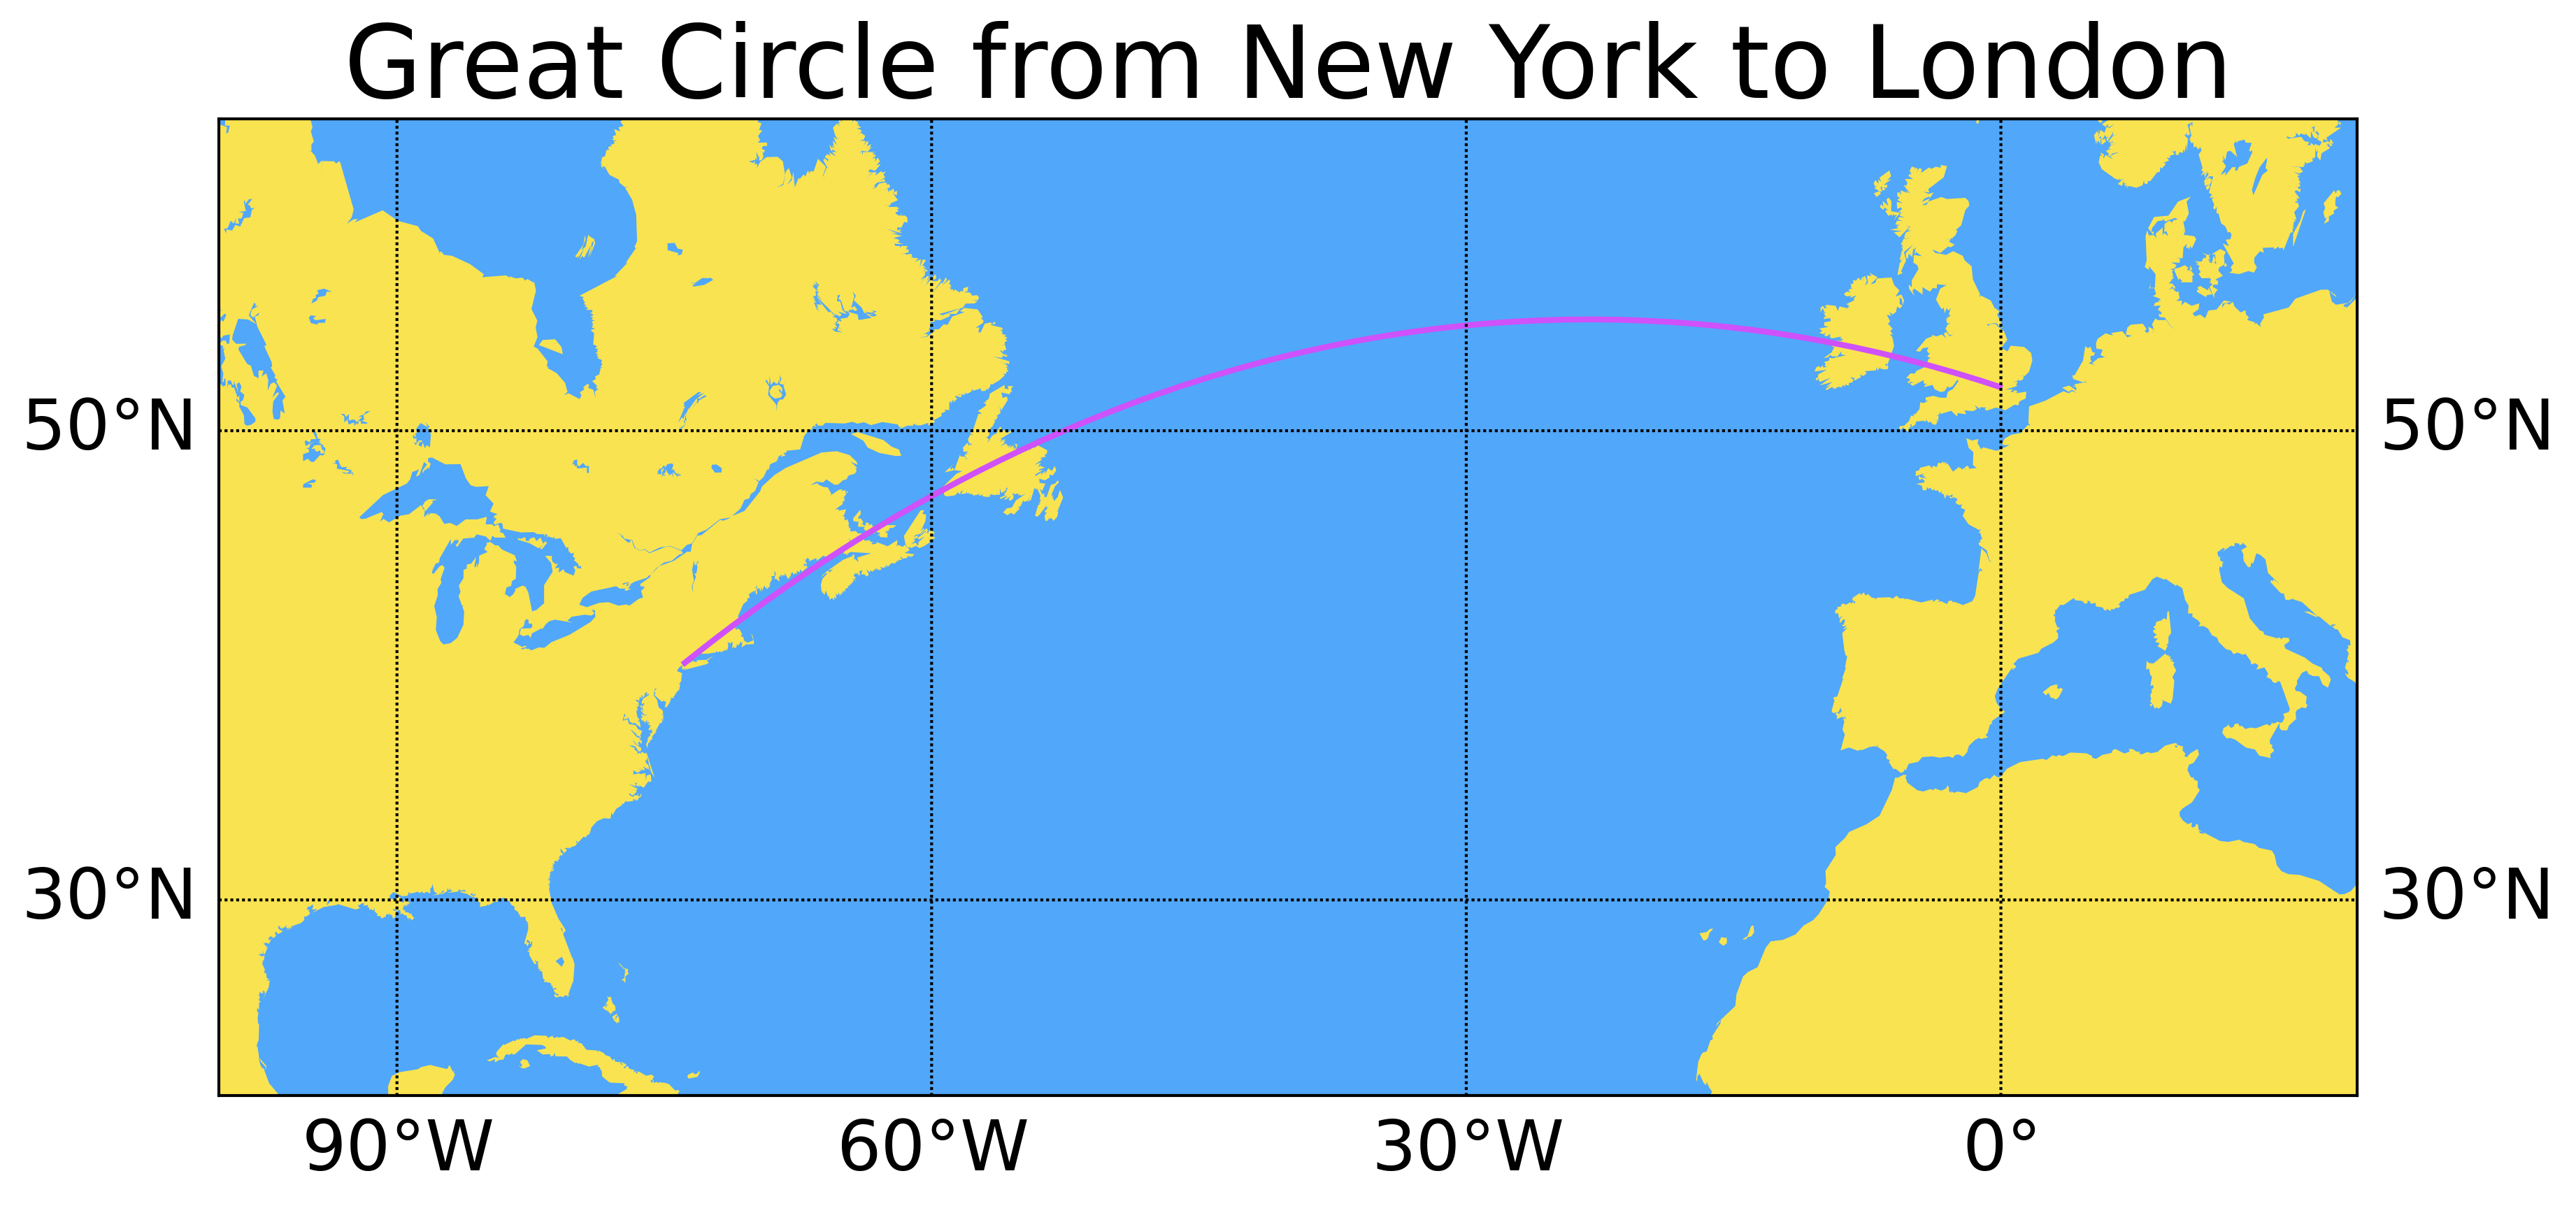

In [51]:
m = Basemap(llcrnrlon=-100.,llcrnrlat=20.,urcrnrlon=20.,urcrnrlat=60.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)

# nylat, nylon are lat/lon of New York
nylat = 40.78
nylon = -73.98
lonlat = 51.53
lonlon = 0.08

# draw great circle route between NY and London
m.drawgreatcircle(nylon,nylat,lonlon,lonlat,linewidth=2,color=colors[1])
m.drawmapboundary(fill_color=colors[0])
m.fillcontinents(color=colors[4],lake_color=colors[0])

# draw parallels
m.drawparallels(np.arange(10,90,20), labels=[1,1,0,1])

# draw meridians
m.drawmeridians(np.arange(-180,180,30), labels=[1,1,0,1])

plt.gca().set_title('Great Circle from New York to London')

Or even plot it on the globe

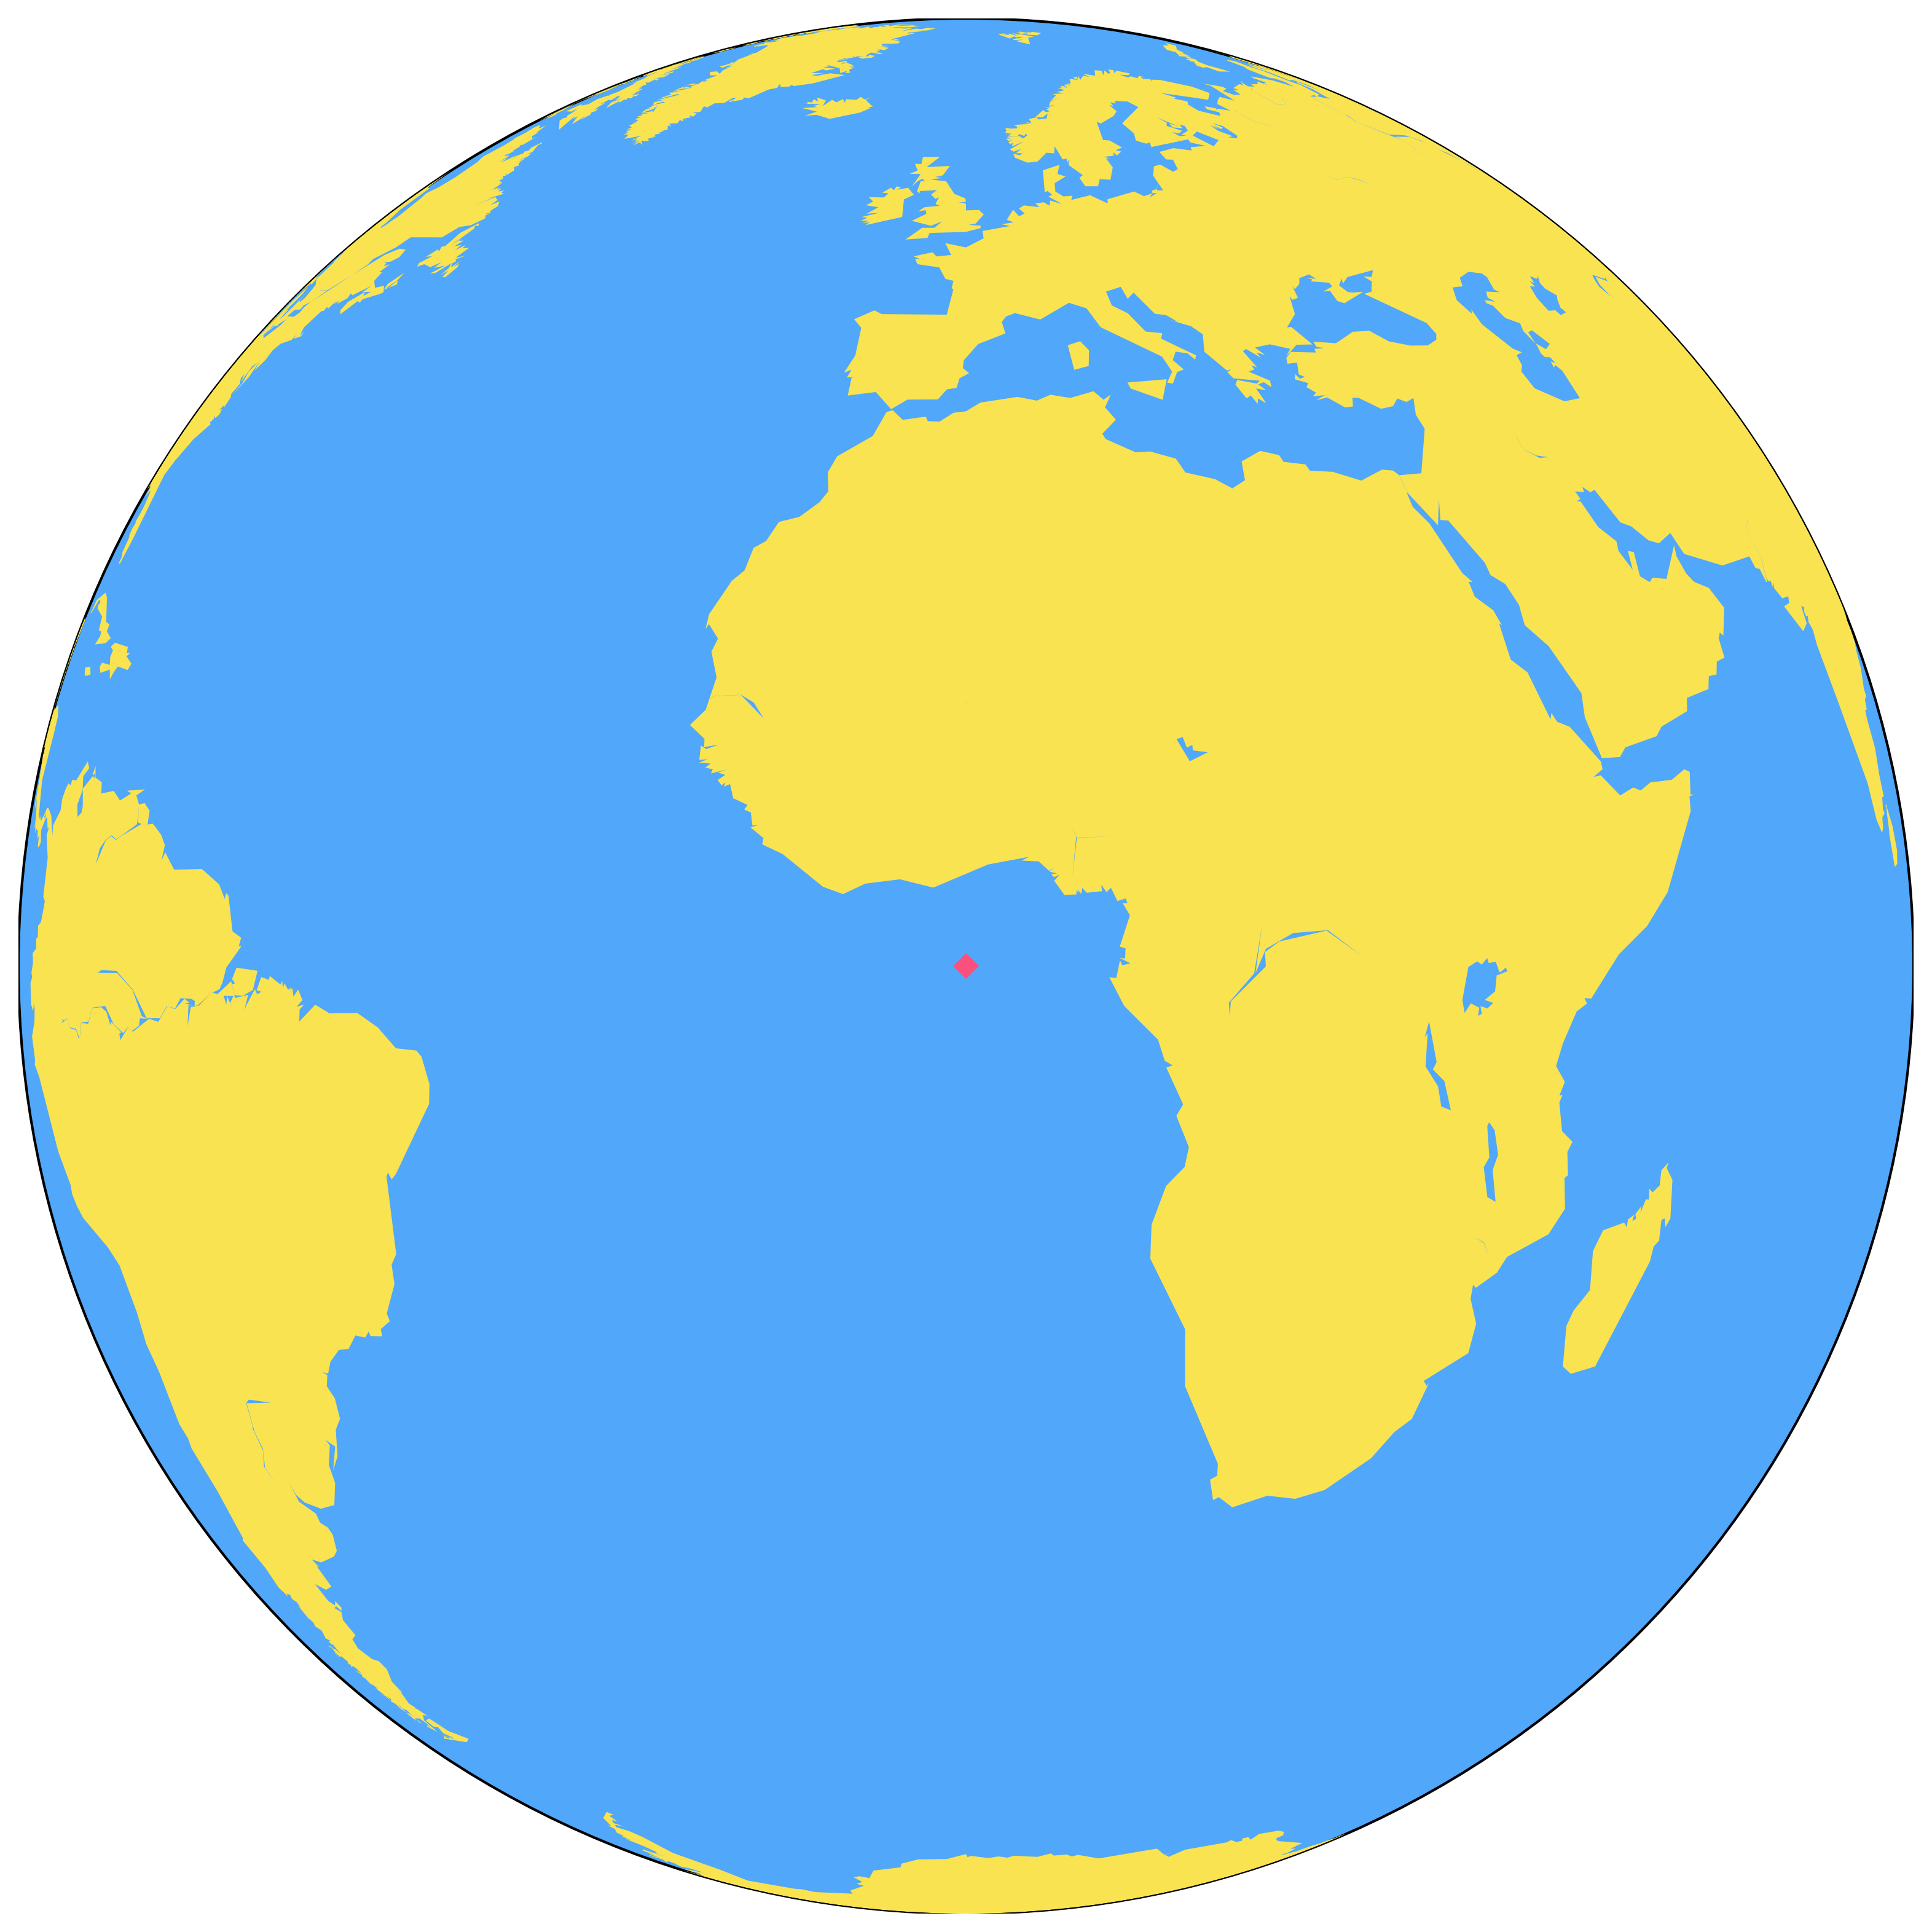

In [52]:
m = Basemap(projection='ortho', lat_0=0, lon_0=0)

m.drawmapboundary(fill_color=colors[0])
m.fillcontinents(color=colors[4],lake_color=colors[0])

x, y = m(0, 0)

m.plot(x, y, marker='D',color=colors[5])
plt.gcf().set_size_inches(11, 11)

including the great circles

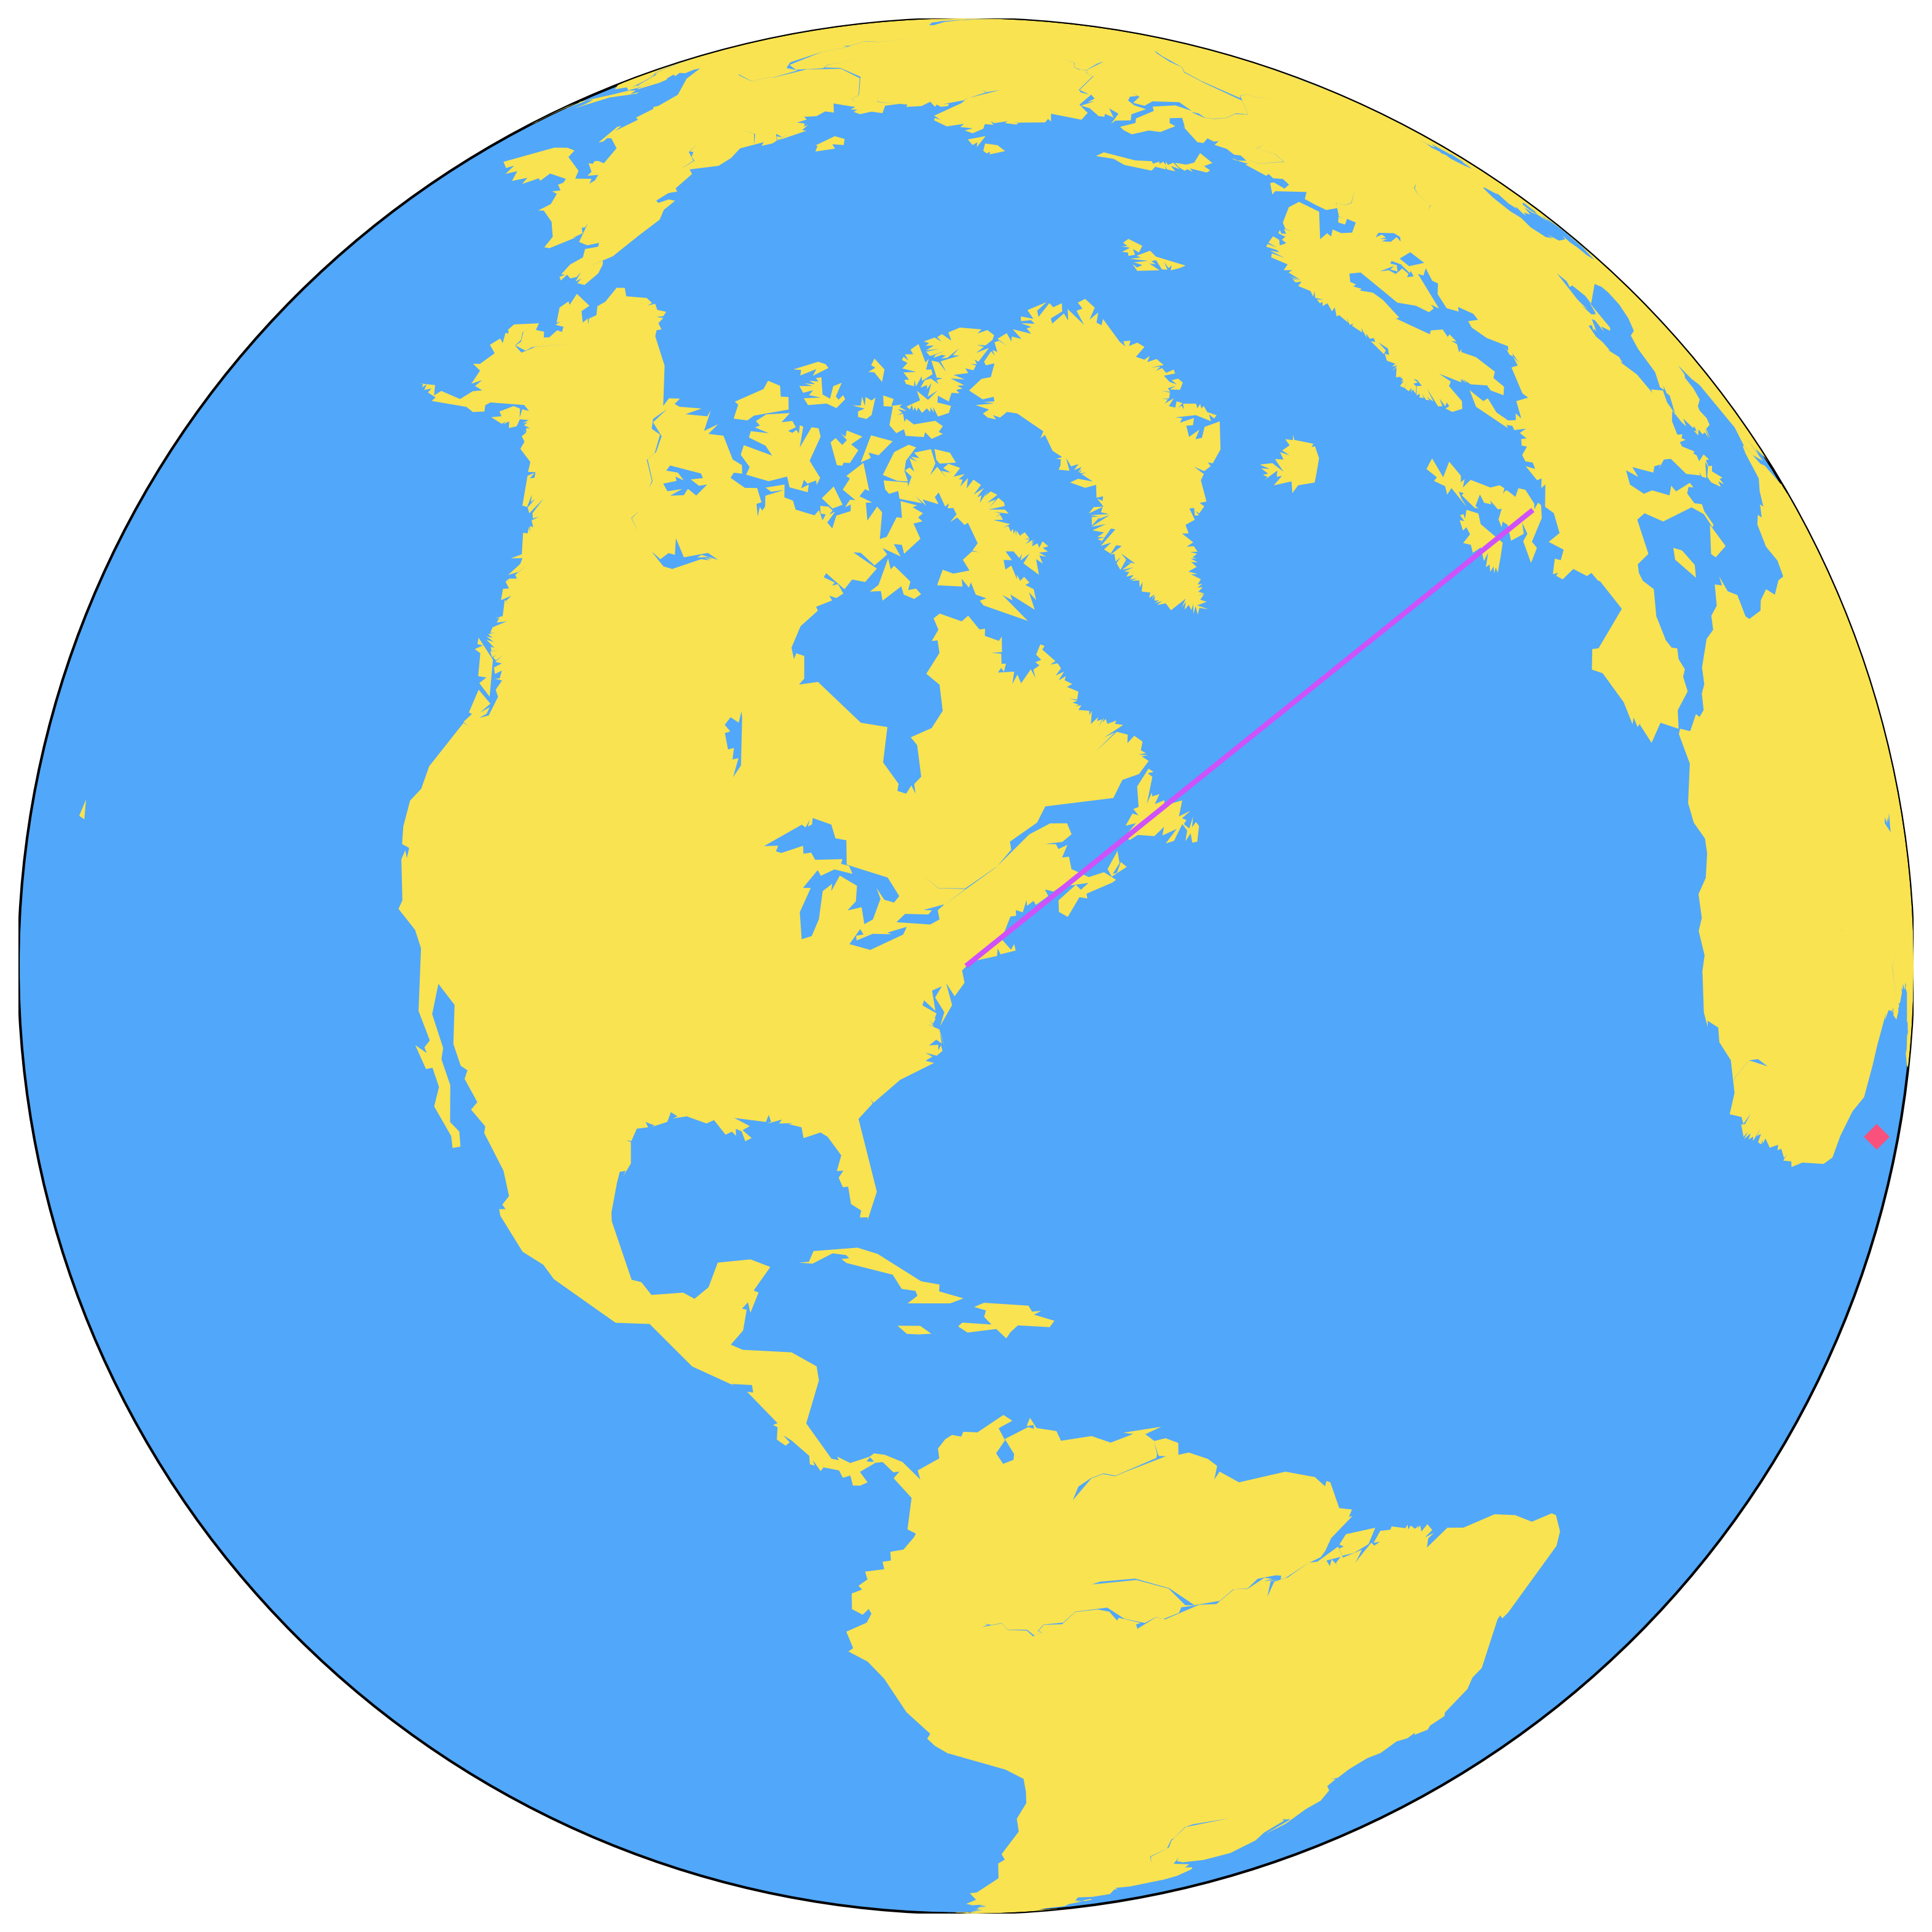

In [53]:
m = Basemap(projection='ortho', lat_0=nylat, lon_0=nylon)

m.drawmapboundary(fill_color=colors[0])
m.fillcontinents(color=colors[4],lake_color=colors[0])

x, y = m(0, 0)

m.plot(x, y, marker='D',color=colors[5])
m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=2, color=colors[1])
plt.gcf().set_size_inches(11, 11)

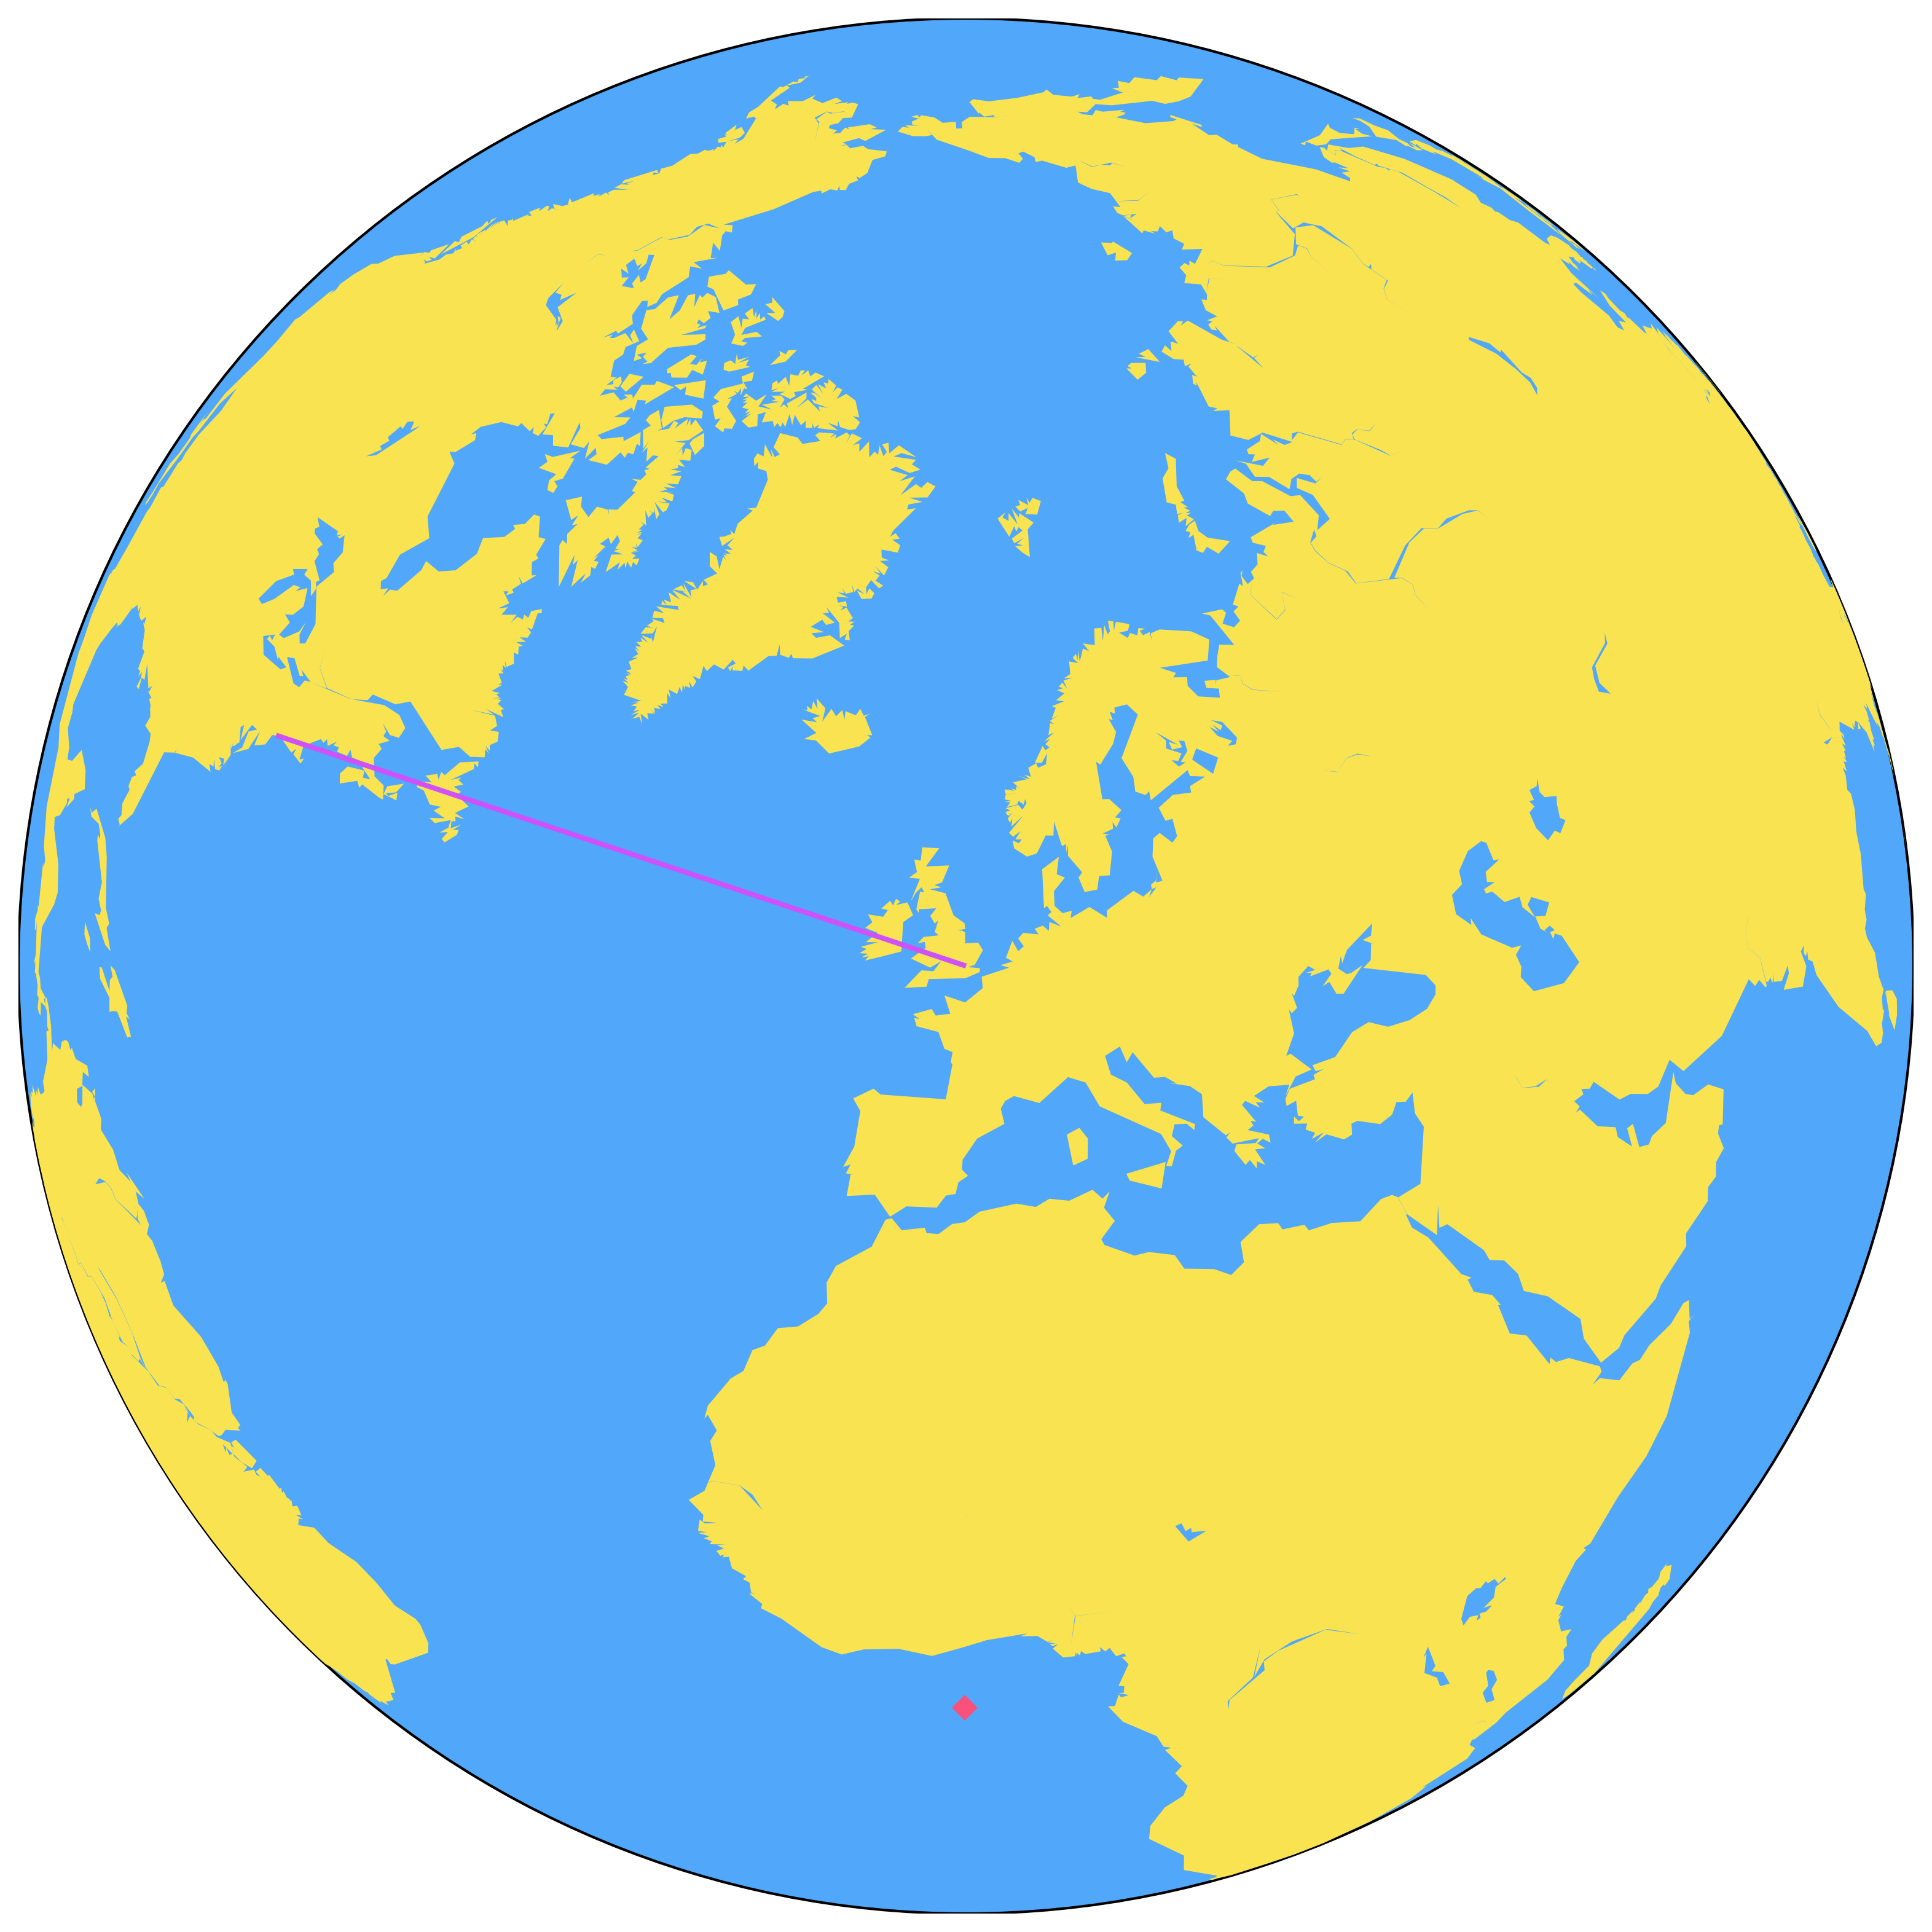

In [54]:
m = Basemap(projection='ortho', lat_0=lonlat, lon_0=lonlon)

m.drawmapboundary(fill_color=colors[0])
m.fillcontinents(color=colors[4],lake_color=colors[0])

x, y = m(0, 0)

m.plot(x, y, marker='D',color=colors[5])
m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=2, color=colors[1])
plt.gcf().set_size_inches(11, 11)